# 8. Random Forest Classification

Let's now build a random forest classification model.

### Load the modules

In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt

### Load dataset

In [2]:
# Read in dataset
devon_cornwall = pd.read_csv('./data/dandc_crime_and_demographics.csv')
# Drop LSOA code - we will add this back in later for mapping
devon_cornwall = devon_cornwall.drop('lsoa_code', axis=1)
# Make data float type
devon_cornwall = devon_cornwall.astype(float)

### Hide warnings

In [3]:
# Hide warnings (to keep notebook tidy)
import warnings
warnings.filterwarnings("ignore")

## Total crime
As ever, let's build our first model for predicting total crime.

### Prepare labels

We are now looking to classify our data as one of a number of labels. Let's try to predict the areas with the highest crime. We will label the top decile 1, and the rest 0.

We will need to do some more processing of the data to create these labels:

In [4]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['crime_total'], bin_edges = pd.qcut(devon_cornwall['crime_total'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [5]:
# Have a look at counts
devon_cornwall['crime_total'].value_counts()

0    930
1    104
Name: crime_total, dtype: int64

In [6]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0       47.0     0
1      819.7     1

### Divide into features (X) and labels (y)

We will split into features (X) and labels (y) and convert these from pandas dataframes to NumPy arrays. These are simpler to refer to by row/column index numbers, which we will use for sklearn's k-fold method.

In [7]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['crime_total'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

### Build random forest model

Let's define a function to build an initial random forest model so we can use it for other crime types.

In [8]:
# Define function for fitting initial random forest regression model
def initial_rf_regression(X,y):
    
    # Set up lists to hold results for each k-fold run
    training_acc_results = []
    test_acc_results = []
    
    # Set up DataFrame for feature importances
    importances = pd.DataFrame(index = list(X_df))
    
    # Set up splits
    number_of_splits = 10
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = 42)
    skf.get_n_splits(X, y)
    
    # Loop through the k-fold splits
    k_fold_count = 1
    for train_index, test_index in skf.split(X, y):
    
        # Get X and Y train/test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index] 
        
        # Set up and fit model
        model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train) 
        
        # Predict training and test set labels
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate accuracy of training and test sets
        accuracy_train = np.mean(y_pred_train == y_train)
        accuracy_test = np.mean(y_pred_test == y_test)

        # Add accuracy to lists
        training_acc_results.append(accuracy_train)
        test_acc_results.append(accuracy_test)
        
        # Record feature importances
        col_title = 'split_' + str(k_fold_count)
        importances[col_title] = model.feature_importances_
        k_fold_count +=1
    
    # Get average of feature importances, and sort
    importances['mean'] = importances.mean(axis=1)
    importances.sort_values(by='mean',ascending=False, inplace=True)
    
    # Return mean and test accuracies and importances
    return training_acc_results, test_acc_results, importances

In [9]:
initial = initial_rf_regression(X,y)

In [10]:
# Show mean accuracy on training data
initial[0]

[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9989258861439313]

In [11]:
# Show mean accuracy on test data
initial[1]

[0.9038461538461539,
 0.9423076923076923,
 0.9326923076923077,
 0.9326923076923077,
 0.970873786407767,
 0.9514563106796117,
 0.970873786407767,
 0.912621359223301,
 0.941747572815534,
 0.9320388349514563]

In [12]:
# Define function to plot initial accuracy
def plot_initial_accuracy(initial):
    # Plot the accuracy
    %matplotlib inline

    # Set up X data 
    x_for_box = [initial[0], initial[1]]

    # Set up X labels
    labels = ['Training', 'Test'] 

    # Set up figure
    fig = plt.figure(figsize=(5,5))

    # Add subplot (can be used to define multiple plots in same figure)
    ax1 = fig.add_subplot(1,1,1)

    # Define Box Plot (`widths` is optional)
    ax1.boxplot(x_for_box, 
                widths=0.7,
                whis=10)

    # Set X and Y labels
    ax1.set_xticklabels(labels)
    ax1.set_ylabel('Accuracy')

    # Show plot
    plt.show()

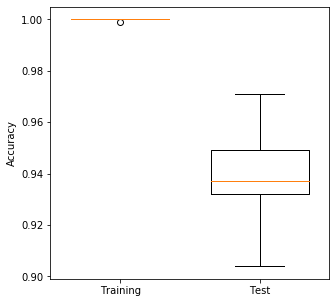

In [13]:
plot_initial_accuracy(initial)

Let's look at the top features ordered by importance:

In [14]:
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5  \
room_rating             0.040862  0.043956  0.033525  0.043344  0.040498   
married                 0.037757  0.037483  0.040751  0.038142  0.038814   
two_plus_cars           0.047211  0.028858  0.044507  0.026978  0.026022   
private_rent            0.031396  0.028873  0.033269  0.032422  0.031033   
flat                    0.034192  0.019488  0.016268  0.029206  0.023513   
wider_barriers          0.023804  0.027935  0.022324  0.028230  0.023588   
british_birth           0.029524  0.019244  0.018597  0.019228  0.028936   
new_eu_birth            0.022597  0.027757  0.021182  0.021894  0.019926   
owners                  0.014881  0.023445  0.027338  0.020503  0.021691   
semi_detached           0.024125  0.013208  0.015467  0.027429  0.011241   
imd                     0.017426  0.017402  0.017975  0.025736  0.017200   
mixed                   0.013169  0.021415  0.015181  0.016083  0.017271   
divorced                0.017941  0.017111  0.014370  0.017455  0.019154   
unemployment            0.016891  0.016604  0.017903  0.009183  0.014893   
single                  0.011533  0.020225  0.016409  0.012556  0.011100   
idaopi                  0.018771  0.013809  0.011434  0.012497  0.012848   
language                0.009787  0.010801  0.012301  0.008188  0.013177   
non_dependent_children  0.015438  0.011770  0.011649  0.012008  0.013788   
health_score            0.013076  0.008369  0.010941  0.014582  0.011398   
private_transport       0.006791  0.012864  0.009934  0.012385  0.010946   
employment_score        0.007987  0.007462  0.011367  0.009725  0.009217   
income_score            0.008647  0.004540  0.009597  0.008385  0.008945   
white                   0.008022  0.010315  0.010194  0.006461  0.008499   
f_24                    0.005632  0.004664  0.005876  0.011112  0.008806   
alternative_transport   0.003794  0.006670  0.009694  0.006587  0.006393   
illness                 0.008360  0.007111  0.012917  0.005264  0.007074   
chinese                 0.008283  0.007189  0.008581  0.007694  0.011423   
m_25                    0.005605  0.006489  0.006841  0.011379  0.004228   
m_51                    0.007763  0.006966  0.008284  0.005059  0.006218   
unpaid_care             0.006631  0.003617  0.004994  0.008362  0.005760   

                         split_6   split_7   split_8   split_9  split_10  \
room_rating             0.044622  0.037061  0.043167  0.038799  0.042483   
married                 0.038425  0.043336  0.043914  0.041956  0.036492   
two_plus_cars           0.031393  0.024254  0.025104  0.030857  0.029808   
private_rent            0.029920  0.036517  0.035628  0.022325  0.028256   
flat                    0.022742  0.021782  0.023406  0.022750  0.032821   
wider_barriers          0.024071  0.024081  0.023173  0.024555  0.022628   
british_birth           0.028651  0.025014  0.020605  0.021151  0.018201   
new_eu_birth            0.022431  0.021066  0.025158  0.021280  0.019389   
owners                  0.017623  0.023101  0.019395  0.025900  0.019682   
semi_detached           0.019663  0.026149  0.033295  0.016893  0.016915   
imd                     0.021337  0.017208  0.023235  0.023433  0.016340   
mixed                   0.025699  0.010810  0.017900  0.013744  0.021182   
divorced                0.013003  0.009254  0.013454  0.018918  0.013624   
unemployment            0.013613  0.009752  0.013267  0.015950  0.016047   
single                  0.016532  0.013657  0.007351  0.013629  0.012664   
idaopi                  0.009963  0.014795  0.013232  0.011887  0.008265   
language                0.009420  0.017789  0.011364  0.011407  0.016362   
non_dependent_children  0.009884  0.006149  0.011773  0.006175  0.011091   
health_score            0.008074  0.009276  0.011332  0.009934  0.009452   
private_transport       0.008870  0.009031  0.005710  0.010466  0.007778   
employment_score        0.010451  0.006655  0.008245  0.012242  0.010821

The mean test accuracy is already better than our initial logistic regression model, but let's see if we can optimise the random forest parameters using a random search. Before we do this however, we will need to do some feature selection, as 256 features is a lot to run through the random search. Let's visualise the effect of different numbers of features.

### Feature selection

In [15]:
# Create list of ordered features
ordered_features = initial[2].index.values.tolist()

# Create list to store accuracy
accuracy_by_feature_number = []
roc_auc_by_feature_number = []

# Loop through feature list
number_of_features = len(ordered_features)
for i in range(number_of_features):
    
    features_to_use = ordered_features[0:i+1]
    X_selected = X_df[features_to_use]
    
    # Convert dataframes to NumPy arrays
    X_np = X_selected.to_numpy()
    y_np = y_df.to_numpy()
    
    # Run k fold model
    # Set up list to hold results for each k-fold run
    test_accuracy_results = []
    test_auc_results = []

    # Set up splits
    number_of_splits = 10
    seed = 42
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = seed)
    skf.get_n_splits(X_np, y_df)
    
    # Loop through the k-fold splits
    k_fold_count = 0
    for train_index, test_index in skf.split(X_np, y_np):
        
        # Get X and Y train/test
        X_train, X_test = X_np[train_index], X_np[test_index]
        y_train, y_test = y_df[train_index], y_df[test_index]
        
        # Set up and fit model
        model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        model.fit(X_train,y_train)
        
        # Predict test set labels
        y_pred_test = model.predict(X_test)
        
        # Calculate accuracy of test sets
        accuracy_test = np.mean(y_pred_test == y_test)
        
        # Get ROC AUC
        probabilities = model.predict_proba(X_test)
        probabilities = probabilities[:, 1] # Probability of high crime class
        fpr, tpr, thresholds = roc_curve(y_test, probabilities)
        roc_auc = auc(fpr, tpr)
        
        # Add to lists
        test_accuracy_results.append(accuracy_test)
        test_auc_results.append(roc_auc)
        k_fold_count +=1
        
    # Add mean accuracy to record by feature number
    accuracy_by_feature_number.append(np.mean(test_accuracy_results))
    roc_auc_by_feature_number.append(np.mean(test_auc_results))

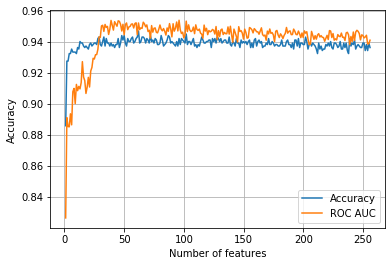

In [16]:
# Plot accuracy and ROC
%matplotlib inline

chart_x = list(range(1, number_of_features + 1))
plt.plot(chart_x, accuracy_by_feature_number,
        label = 'Accuracy')

plt.plot(chart_x, roc_auc_by_feature_number,
        label = 'ROC AUC')

plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

This graph suggests that we might do well to try 30 features. 

### Random search

In [17]:
# Define function to select top 30 features
def top_30_features(initial):
    top_features = initial[2].index.values.tolist()[0:30]
    return top_features

In [18]:
top_features = top_30_features(initial)

In [19]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('crime_total')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('crime_total',axis=1) 
y_df = feature_selected['crime_total'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [20]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [21]:
# Define function to fit random search model

def random_search(random_grid,X,y):

    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, 
                               random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(X, y)
    # Store best parameters
    best_params = rf_random.best_params_
    
    return best_params

In [22]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.1min finished


{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': False}

Let's try the random forest regression model again with these best parameters.

In [23]:
# Define a function to apply a random forest regression model with the results of the random search
def best_rf_regression(X,y):

    # Set up lists to hold results for each k-fold run
    training_accuracy_results = []
    test_accuracy_results = []
    training_auc_results = []
    test_auc_results = []
    
    # Set up splits
    number_of_splits = 10
    seed = 42
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = seed)
    skf.get_n_splits(X, y)
    
    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X, y):
    
        # Get X and Y train/test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Set up and fit model with best parameters
        model = RandomForestClassifier(n_estimators=best_parameters["n_estimators"],
                                      random_state=42,
                                      min_samples_leaf = best_parameters["min_samples_leaf"], 
                                      min_samples_split = best_parameters["min_samples_split"],
                                      max_features = best_parameters["max_features"], 
                                      max_depth = best_parameters["max_depth"], 
                                      bootstrap = best_parameters["bootstrap"])
        model.fit(X_train, y_train) 
        
        # Predict training and test set labels
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
        
        # Calculate accuracy of training and test sets
        accuracy_train = np.mean(y_pred_train == y_train)
        accuracy_test = np.mean(y_pred_test == y_test)
        
        # Get training ROC AUC
        probabilities = model.predict_proba(X_train)
        probabilities = probabilities[:, 1] # Probability of high crime class
        fpr, tpr, thresholds = roc_curve(y_train, probabilities)
        train_roc_auc = auc(fpr, tpr)
        
        # Get test ROC AUC
        probabilities = model.predict_proba(X_test)
        probabilities = probabilities[:, 1] # Probability of high crime class
        fpr, tpr, thresholds = roc_curve(y_test, probabilities)
        test_roc_auc = auc(fpr, tpr)
        
        # Add to lists
        training_accuracy_results.append(accuracy_train)
        test_accuracy_results.append(accuracy_test)
        training_auc_results.append(train_roc_auc)
        test_auc_results.append(test_roc_auc)
        
    # Calculate mean training and test accuracies and ROC
    mean_training_accuracy = np.mean(training_accuracy_results)
    mean_test_accuracy = np.mean(test_accuracy_results)
    mean_training_auc = np.mean(training_auc_results)
    mean_test_auc = np.mean(test_auc_results)
    
    # Return mean and test errors and importances
    return mean_training_accuracy, mean_test_accuracy, mean_training_auc, mean_test_auc

In [24]:
best = best_rf_regression(X,y)

Let's have a look at the accuracies.

In [25]:
best[0:2]

(1.0, 0.9362303958177745)

The test accuracy has increased. 

And the ROC AUC:

In [26]:
best[2:4]

(1.0, 0.9458846529814272)

### Dealing with imbalanced data

Our data is highly imbalanced, so the model may end up biased towards the majority class and under-predicting the minority class. Let's try changing the probability thresholds to deal with this. 

In [27]:
# Define function to calculate various accuracy measurements
def calculate_accuracy(observed, predicted):
    
    """
    Calculates a range of accuracy scores from observed and predicted classes.
    
    Takes two list or NumPy arrays (observed class values, and predicted class 
    values), and returns a dictionary of results.
    
     1) observed positive rate: proportion of observed cases that are +ve
     2) Predicted positive rate: proportion of predicted cases that are +ve
     3) observed negative rate: proportion of observed cases that are -ve
     4) Predicted negative rate: proportion of predicted cases that are -ve  
     5) accuracy: proportion of predicted results that are correct    
     6) precision: proportion of predicted +ve that are correct
     7) recall: proportion of true +ve correctly identified
     8) f1: harmonic mean of precision and recall
     9) sensitivity: Same as recall
    10) specificity: Proportion of true -ve identified:        
    11) positive likelihood: increased probability of true +ve if test +ve
    12) negative likelihood: reduced probability of true +ve if test -ve
    13) false positive rate: proportion of false +ves in true -ve patients
    14) false negative rate: proportion of false -ves in true +ve patients
    15) true positive rate: Same as recall
    16) true negative rate
    17) positive predictive value: chance of true +ve if test +ve
    18) negative predictive value: chance of true -ve if test -ve
    
    """
    
    # Converts list to NumPy arrays
    if type(observed) == list:
        observed = np.array(observed)
    if type(predicted) == list:
        predicted = np.array(predicted)
    
    # Calculate accuracy scores
    observed_positives = observed == 1
    observed_negatives = observed == 0
    predicted_positives = predicted == 1
    predicted_negatives = predicted == 0
    
    true_positives = (predicted_positives == 1) & (observed_positives == 1)
    
    false_positives = (predicted_positives == 1) & (observed_positives == 0)
    
    true_negatives = (predicted_negatives == 1) & (observed_negatives == 1)
    
    accuracy = np.mean(predicted == observed)
    
    precision = (np.sum(true_positives) /
                 (np.sum(true_positives) + np.sum(false_positives)))
        
    recall = np.sum(true_positives) / np.sum(observed_positives)
    
    sensitivity = recall
    
    f1 = 2 * ((precision * recall) / (precision + recall))
    
    specificity = np.sum(true_negatives) / np.sum(observed_negatives)
    
    positive_likelihood = sensitivity / (1 - specificity)
    
    negative_likelihood = (1 - sensitivity) / specificity
    
    false_positive_rate = 1 - specificity
    
    false_negative_rate = 1 - sensitivity
    
    true_positive_rate = sensitivity
    
    true_negative_rate = specificity
    
    positive_predictive_value = (np.sum(true_positives) / 
                                 np.sum(observed_positives))
    
    negative_predictive_value = (np.sum(true_negatives) / 
                                  np.sum(observed_positives))
    
    # Create dictionary for results, and add results
    results = dict()
    
    results['observed_positive_rate'] = np.mean(observed_positives)
    results['observed_negative_rate'] = np.mean(observed_negatives)
    results['predicted_positive_rate'] = np.mean(predicted_positives)
    results['predicted_negative_rate'] = np.mean(predicted_negatives)
    results['accuracy'] = accuracy
    results['precision'] = precision
    results['recall'] = recall
    results['f1'] = f1
    results['sensitivity'] = sensitivity
    results['specificity'] = specificity
    results['positive_likelihood'] = positive_likelihood
    results['negative_likelihood'] = negative_likelihood
    results['false_positive_rate'] = false_positive_rate
    results['false_negative_rate'] = false_negative_rate
    results['true_positive_rate'] = true_positive_rate
    results['true_negative_rate'] = true_negative_rate
    results['positive_predictive_value'] = positive_predictive_value
    results['negative_predictive_value'] = negative_predictive_value
    
    return results

In [28]:
# Define function to check different probability thresholds
def check_thresholds(X,y):
    
    # Set up k-fold training/test splits
    number_of_splits = 10
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = 42)
    skf.get_n_splits(X, y)

    # Set up thresholds
    thresholds = np.arange(0, 1.01, 0.01)

    # Create arrays for overall results (rows=threshold, columns=k fold replicate)
    results_accuracy = np.zeros((len(thresholds),number_of_splits))
    results_precision = np.zeros((len(thresholds),number_of_splits))
    results_recall = np.zeros((len(thresholds),number_of_splits))
    results_f1 = np.zeros((len(thresholds),number_of_splits))
    results_predicted_positive_rate = np.zeros((len(thresholds),number_of_splits))
    results_observed_positive_rate = np.zeros((len(thresholds),number_of_splits))
    results_true_positive_rate = np.zeros((len(thresholds),number_of_splits))
    results_false_positive_rate = np.zeros((len(thresholds),number_of_splits))
    results_auc = []

    # Loop through the k-fold splits
    loop_index = 0
    for train_index, test_index in skf.split(X, y):

        # Create lists for k-fold results
        threshold_accuracy = []
        threshold_precision = []
        threshold_recall = []
        threshold_f1 = []
        threshold_predicted_positive_rate = []
        threshold_observed_positive_rate = []
        threshold_true_positive_rate = []
        threshold_false_positive_rate = []

        # Get X and Y train/test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Set up and fit model (n_jobs=-1 uses all cores on a computer)
        model = RandomForestClassifier(n_estimators=best_parameters["n_estimators"],
                                       random_state=42,
                                       min_samples_leaf = best_parameters["min_samples_leaf"], 
                                       min_samples_split = best_parameters["min_samples_split"],
                                       max_features = best_parameters["max_features"], 
                                       max_depth = best_parameters["max_depth"], 
                                       bootstrap = best_parameters["bootstrap"],
                                       n_jobs=-1)
        model.fit(X_train,y_train)

        # Get probabilities
        probabilities = model.predict_proba(X_test)
        # Take just the high crime probabilities (column 1)
        probability_high_crime = probabilities[:,1]

        # Loop through increments in probability of high crime
        for cutoff in thresholds: #  loop 0 --> 1 on steps of 0.1
            # Get whether LSOA is high crime using cutoff
            predicted_high_crime = probability_high_crime >= cutoff
            # Call accuracy measures function
            accuracy = calculate_accuracy(y_test, predicted_high_crime)
            # Add accuracy scores to lists
            threshold_accuracy.append(accuracy['accuracy'])
            threshold_precision.append(accuracy['precision'])
            threshold_recall.append(accuracy['recall'])
            threshold_f1.append(accuracy['f1'])
            threshold_predicted_positive_rate.append(
                    accuracy['predicted_positive_rate'])
            threshold_observed_positive_rate.append(
                    accuracy['observed_positive_rate'])
            threshold_true_positive_rate.append(accuracy['true_positive_rate'])
            threshold_false_positive_rate.append(accuracy['false_positive_rate'])

        # Add results to results arrays
        results_accuracy[:,loop_index] = threshold_accuracy
        results_precision[:, loop_index] = threshold_precision
        results_recall[:, loop_index] = threshold_recall
        results_f1[:, loop_index] = threshold_f1
        results_predicted_positive_rate[:, loop_index] = \
            threshold_predicted_positive_rate
        results_observed_positive_rate[:, loop_index] = \
            threshold_observed_positive_rate
        results_true_positive_rate[:, loop_index] = threshold_true_positive_rate
        results_false_positive_rate[:, loop_index] = threshold_false_positive_rate

        # Calculate ROC AUC
        roc_auc = auc(threshold_false_positive_rate, threshold_true_positive_rate)
        results_auc.append(roc_auc)

        # Increment loop index
        loop_index += 1


    # Transfer summary results to dataframe
    results = pd.DataFrame(thresholds, columns=['thresholds'])
    results['accuracy'] = results_accuracy.mean(axis=1)
    results['precision'] = results_precision.mean(axis=1)
    results['recall'] = results_recall.mean(axis=1)
    results['f1'] = results_f1.mean(axis=1)
    results['predicted_positive_rate'] = \
        results_predicted_positive_rate.mean(axis=1)
    results['observed_positive_rate'] = \
        results_observed_positive_rate.mean(axis=1)
    results['true_positive_rate'] = results_true_positive_rate.mean(axis=1)
    results['false_positive_rate'] = results_false_positive_rate.mean(axis=1)
    results['roc_auc'] = np.mean(results_auc)

    mean_auc = np.mean(results_auc)
    mean_auc = np.round(mean_auc, 3)
    
    # Plot ROC curve
    for i in range(number_of_splits):
        plt.plot(results_false_positive_rate[:, i],
                 results_true_positive_rate[:, i],
                 color='black',
                 linestyle=':',
                 linewidth=1)
    plt.plot(results_false_positive_rate.mean(axis=1),
             results_true_positive_rate.mean(axis=1),
             color='red',
             linestyle='-',
             linewidth=2)
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate (1 - Specificity)')
    plt.ylabel('True Positive Rate (Sensitivity)')
    plt.title('Receiver Operator Characteristic (ROC) Curve')
    plt.grid(True)
    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    text = "Mean AUC = " + str(mean_auc)
    plt.text(0.65, 0.08, text, bbox=props)
    plt.show()
    
    return results

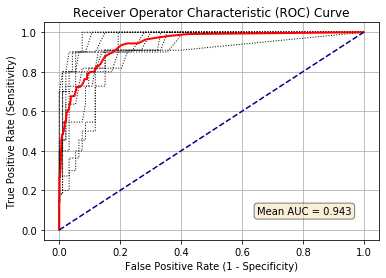

In [29]:
results = check_thresholds(X,y)

In [30]:
# Define function to plot effects of changing classification probability threshold
def plot_thresholds(results):
    chart_x = results['thresholds']

    plt.plot(chart_x, results['accuracy'],
             linestyle = '-',
             label = 'Accuracy')

    plt.plot(chart_x, results['precision'],
             linestyle = '--',
             label = 'Precision')

    plt.plot(chart_x, results['recall'],
             linestyle = '-.',
             label = 'Recall')

    plt.plot(chart_x, results['f1'],
             linestyle = ':',
             label = 'F1')

    plt.plot(chart_x, results['predicted_positive_rate'],
             linestyle = '-',
             label = 'Predicted positive rate')

    plt.plot(chart_x, results['observed_positive_rate'],
             linestyle = '--',
             color='k',
             label = 'Observed positive rate')


    plt.xlabel('Probability cutoff for classification')
    plt.ylabel('Score')
    plt.ylim(-0.02, 1.02)
    plt.legend(loc='center right')
    plt.grid(True)

    plt.show()

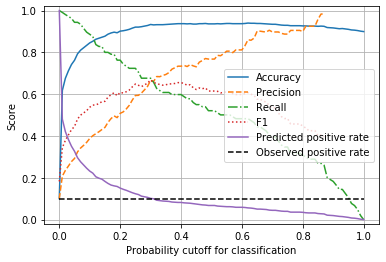

In [31]:
plot_thresholds(results)

A probability threshold of about 0.3 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final function:

In [32]:
threshold = 0.3

In [33]:
# Define function to apply final model with selected thresholds
def final_random_forest(X, y):
    
    # Set up splits
    number_of_splits = 10
    seed = 42
    skf = StratifiedKFold(n_splits = number_of_splits, shuffle = True, random_state = seed)
    skf.get_n_splits(X, y)
    
    # Create lists for k-fold results
    k_fold_accuracy = []
    k_fold_precision = []
    k_fold_recall = []
    k_fold_f1 = []
    k_fold_predicted_positive_rate = []
    k_fold_observed_positive_rate = []
    k_fold_true_positive_rate = []
    k_fold_false_positive_rate = []

    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X, y):
    
        # Get X and Y train/test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Set up and fit model with best parameters
        model = RandomForestClassifier(n_estimators=best_parameters["n_estimators"],
                                       random_state=42,
                                       min_samples_leaf = best_parameters["min_samples_leaf"], 
                                       min_samples_split = best_parameters["min_samples_split"],
                                       max_features = best_parameters["max_features"], 
                                       max_depth = best_parameters["max_depth"], 
                                       bootstrap = best_parameters["bootstrap"],
                                       n_jobs=-1)
        model.fit(X_train, y_train) 
        
        # Get probabilities
        probabilities = model.predict_proba(X_test)
        # Take just the high crime probabilities (column 1)
        probability_high_crime = probabilities[:,1]
        
        # Get whether high crime using cutoff
        predicted_high_crime = probability_high_crime >= threshold
        # Call accuracy measures function
        accuracy = calculate_accuracy(y_test, predicted_high_crime)
        # Add accuracy scores to lists
        k_fold_accuracy.append(accuracy['accuracy'])
        k_fold_precision.append(accuracy['precision'])
        k_fold_recall.append(accuracy['recall'])
        k_fold_f1.append(accuracy['f1'])
        k_fold_predicted_positive_rate.append(accuracy['predicted_positive_rate'])
        k_fold_observed_positive_rate.append(accuracy['observed_positive_rate'])
        k_fold_true_positive_rate.append(accuracy['true_positive_rate'])
        k_fold_false_positive_rate.append(accuracy['false_positive_rate'])
        
    # Show accuracy results
    mean_accuracy = np.mean(k_fold_accuracy)
    mean_precision = np.mean(k_fold_precision)
    mean_recall = np.mean(k_fold_recall)
    mean_f1 = np.mean(k_fold_f1)
    mean_predicted_positive_rate = np.mean(k_fold_predicted_positive_rate)
    mean_observed_positive_rate = np.mean(k_fold_observed_positive_rate)
    mean_true_positive_rate = np.mean(k_fold_true_positive_rate)
    mean_false_positive_rate = np.mean(k_fold_false_positive_rate)
    
    results = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_predicted_positive_rate, 
              mean_observed_positive_rate, mean_true_positive_rate, mean_false_positive_rate]
        
    return results    

In [34]:
results = final_random_forest(X,y)

In [35]:
# Look at accuracy
results[0]

0.9333084391336819

In [36]:
# Look at precision and recall
results[1:3]

[0.6658313908313909, 0.6763636363636364]

The results have been well balanced, and are similar to the results for logistic regression.

In [37]:
# Look at predicted positive rate
results[4]

0.1015683345780433

## Antisocial behaviour

Now we will build random forest models for all the different crime types. 

In [38]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['antisocial'], bin_edges = pd.qcut(devon_cornwall['antisocial'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [39]:
# Have a look at counts
devon_cornwall['antisocial'].value_counts()

0    930
1    104
Name: antisocial, dtype: int64

In [40]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        7.0     0
1      244.7     1

In [41]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['antisocial'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [42]:
initial = initial_rf_regression(X,y)

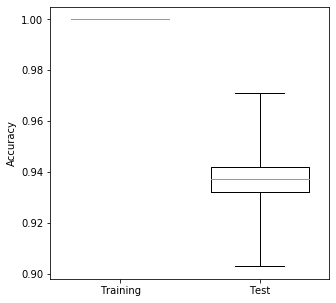

In [43]:
plot_initial_accuracy(initial)

In [44]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5  \
two_plus_cars           0.053685  0.049811  0.052938  0.052326  0.049837   
room_rating             0.037941  0.039111  0.043487  0.048859  0.042171   
married                 0.036045  0.034499  0.037866  0.031023  0.032993   
flat                    0.029377  0.026999  0.031649  0.028994  0.031596   
wider_barriers          0.020005  0.029717  0.019873  0.028420  0.022445   
private_rent            0.020309  0.020663  0.024941  0.023099  0.016483   
divorced                0.016981  0.017499  0.022031  0.024144  0.022485   
imd                     0.015214  0.014885  0.027725  0.014832  0.019909   
semi_detached           0.017818  0.016691  0.019689  0.021942  0.017076   
new_eu_birth            0.023989  0.016631  0.020075  0.014145  0.023194   
idaopi                  0.029760  0.017467  0.014691  0.018547  0.024666   
owners                  0.019490  0.020092  0.016150  0.017403  0.014678   
british_birth           0.015946  0.018286  0.017729  0.018568  0.020172   
unemployment            0.017166  0.013405  0.014207  0.009051  0.014027   
employment_score        0.014909  0.016265  0.013571  0.008058  0.011298   
non_dependent_children  0.008226  0.014526  0.015664  0.015181  0.009116   
private_transport       0.008983  0.013013  0.016972  0.016542  0.016681   
language                0.013627  0.011034  0.009124  0.008692  0.012119   
health_score            0.010967  0.012076  0.013637  0.008542  0.010000   
single                  0.011545  0.013478  0.013615  0.015507  0.014235   
mixed                   0.014057  0.011647  0.009133  0.013328  0.012572   
income_score            0.008808  0.009662  0.008211  0.008788  0.009113   
illness                 0.009847  0.008667  0.010203  0.007915  0.009930   
m_33                    0.007768  0.006657  0.007764  0.007679  0.006696   
alternative_transport   0.003560  0.006802  0.004181  0.008649  0.009371   
white                   0.006549  0.009535  0.007216  0.004269  0.006119   
detached                0.003048  0.006598  0.005200  0.006068  0.004504   
hospitality             0.005244  0.002798  0.005208  0.006334  0.007045   
no_children             0.007752  0.004727  0.007537  0.007957  0.003262   
f_21                    0.008294  0.005004  0.005121  0.005057  0.006291   

                         split_6   split_7   split_8   split_9  split_10  \
two_plus_cars           0.048795  0.055328  0.048948  0.061842  0.054403   
room_rating             0.053260  0.048654  0.045356  0.044743  0.042371   
married                 0.036796  0.028421  0.039784  0.031383  0.042341   
flat                    0.041721  0.034549  0.029786  0.027335  0.035852   
wider_barriers          0.023212  0.023379  0.023003  0.018912  0.022195   
private_rent            0.021582  0.023346  0.028015  0.025176  0.017455   
divorced                0.019844  0.024580  0.020882  0.021213  0.014557   
imd                     0.022370  0.019596  0.022515  0.019916  0.023081   
semi_detached           0.022910  0.027358  0.017273  0.019663  0.018532   
new_eu_birth            0.013210  0.020888  0.024218  0.022572  0.019312   
idaopi                  0.018744  0.019820  0.016562  0.021270  0.013684   
owners                  0.020373  0.015814  0.022198  0.017515  0.024931   
british_birth           0.018051  0.015910  0.024505  0.019411  0.017321   
unemployment            0.015053  0.014592  0.013131  0.014322  0.017046   
employment_score        0.016588  0.008649  0.013977  0.014545  0.012769   
non_dependent_children  0.018320  0.012886  0.011441  0.010210  0.012174   
private_transport       0.008929  0.011481  0.010625  0.007414  0.013315   
language                0.012516  0.017758  0.008230  0.011935  0.014354   
health_score            0.009973  0.015033  0.009485  0.013592  0.014110   
single                  0.008154  0.005615  0.007950  0.013234  0.012384   
mixed                   0.010048  0.010909  0.012043  0.008009  0.010175

In [45]:
top_features = top_30_features(initial)

In [46]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('antisocial')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('antisocial',axis=1) 
y_df = feature_selected['antisocial'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [47]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


{'n_estimators': 1200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': False}

In [48]:
best = best_rf_regression(X,y)

In [49]:
# Look at accuracies
best[0:2]

(1.0, 0.9448749066467513)

In [50]:
# Look at ROC AUC
best[2:4]

(1.0, 0.9473509286412511)

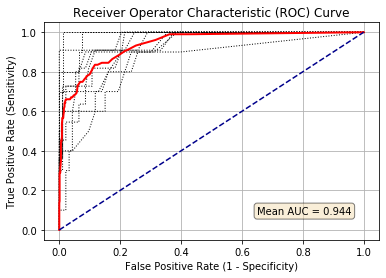

In [51]:
results = check_thresholds(X,y)

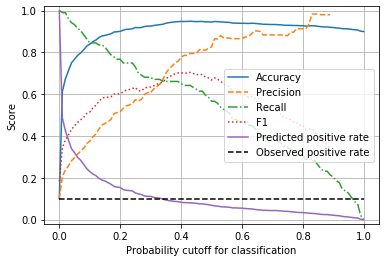

In [52]:
plot_thresholds(results)

A probability threshold of about 0.35 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [53]:
threshold = 0.35

In [54]:
results = final_random_forest(X,y)

In [55]:
# Look at accuracy
results[0]

0.939058999253174

In [56]:
# Look at precision and recall
results[1:3]

[0.698961038961039, 0.6609090909090909]

In [57]:
# Look at predicted positive rate
results[4]

0.09376400298730395

## Bike theft

In [58]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['bike_theft'], bin_edges = pd.qcut(devon_cornwall['bike_theft'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [59]:
# Have a look at counts
devon_cornwall['bike_theft'].value_counts()

0    933
1    101
Name: bike_theft, dtype: int64

In [60]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        6.0     1

In [61]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['bike_theft'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [62]:
initial = initial_rf_regression(X,y)

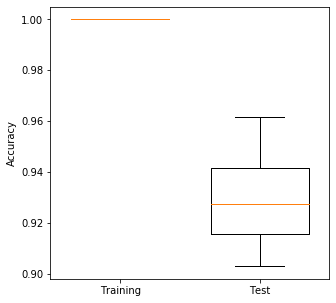

In [63]:
plot_initial_accuracy(initial)

In [64]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4  \
british_birth                 0.038062  0.028183  0.026748  0.022588   
married                       0.023668  0.029845  0.028488  0.027392   
mixed                         0.024502  0.028191  0.025522  0.022649   
private_transport             0.026319  0.025757  0.023567  0.026329   
white                         0.024560  0.024081  0.022534  0.023484   
alternative_transport         0.021360  0.027156  0.020988  0.015521   
room_rating                   0.022976  0.019844  0.017526  0.019164   
private_rent                  0.018201  0.017455  0.017986  0.016429   
arab                          0.015955  0.007913  0.013632  0.009645   
m_26                          0.015753  0.013080  0.014838  0.018419   
old_eu_birth                  0.010115  0.012299  0.010103  0.009031   
new_eu_birth                  0.021549  0.011419  0.014027  0.013868   
m_25                          0.018010  0.016997  0.012422  0.014308   
chinese                       0.014200  0.009712  0.007922  0.012315   
single                        0.007044  0.012842  0.007872  0.015701   
indian                        0.008456  0.010920  0.011835  0.011816   
non_dependent_children        0.009206  0.010946  0.008883  0.009504   
flat                          0.012852  0.009376  0.008373  0.010919   
unpaid_care                   0.011480  0.013711  0.006403  0.009048   
two_plus_cars                 0.011130  0.011983  0.009043  0.012868   
f_24                          0.013422  0.012052  0.010040  0.005727   
owners                        0.010621  0.005327  0.007790  0.012387   
m_24                          0.005184  0.006717  0.013702  0.010394   
m_28                          0.011701  0.004955  0.008974  0.011709   
m_22                          0.006044  0.007771  0.005948  0.007351   
storage                       0.008758  0.005750  0.008463  0.006963   
f_21                          0.007129  0.007748  0.009444  0.004917   
semi_detached                 0.007344  0.003286  0.007344  0.003655   
level_one_two_apprenticeship  0.007281  0.004034  0.007959  0.007252   
no_children                   0.003366  0.009014  0.008759  0.006174   

                               split_5   split_6   split_7   split_8  \
british_birth                 0.028160  0.031789  0.030763  0.025111   
married                       0.028402  0.030850  0.031536  0.026180   
mixed                         0.022418  0.026377  0.031381  0.026772   
private_transport             0.018043  0.027759  0.031745  0.029978   
white                         0.022178  0.026655  0.022984  0.026626   
alternative_transport         0.023559  0.020745  0.026790  0.023961   
room_rating                   0.020077  0.011507  0.015597  0.019864   
private_rent                  0.020970  0.020374  0.012867  0.018449   
arab                          0.017112  0.017933  0.016667  0.017570   
m_26                          0.013387  0.013407  0.012577  0.015335   
old_eu_birth                  0.017987  0.015128  0.015762  0.012399   
new_eu_birth                  0.012208  0.013347  0.007240  0.009529   
m_25                          0.010515  0.013994  0.010632  0.007061   
chinese                       0.014932  0.013332  0.011340  0.011029   
single                        0.014604  0.012148  0.013832  0.009683   
indian                        0.010699  0.008880  0.011831  0.011387   
non_dependent_children        0.017464  0.013991  0.009094  0.010092   
flat                          0.011589  0.011066  0.010281  0.012339   
unpaid_care                   0.006513  0.008158  0.007382  0.012460   
two_plus_cars                 0.004568  0.007480  0.012777  0.005284   
f_24                          0.005482  0.008328  0.008214  0.008299   
owners                        0.008331  0.008408  0.007290  0.008275   
m_24                          0.007791  0.017061  0.006464  0.006092   
m_28                          0.008768  0.008855  0.009939  0.007595  

In [65]:
top_features = top_30_features(initial)

In [66]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('bike_theft')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('bike_theft',axis=1) 
y_df = feature_selected['bike_theft'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [67]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.1min finished


{'n_estimators': 1000,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 100,
 'bootstrap': True}

In [68]:
best = best_rf_regression(X,y)

In [69]:
# Look at accuracies
best[0:2]

(0.959488583209175, 0.9303864824495893)

In [70]:
# Look at ROC AUC
best[2:4]

(0.9952602234337293, 0.8877707410411597)

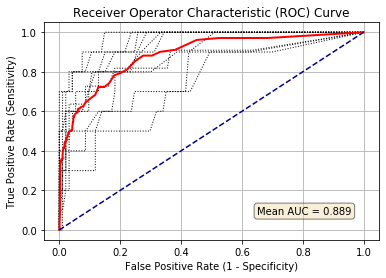

In [71]:
results = check_thresholds(X,y)

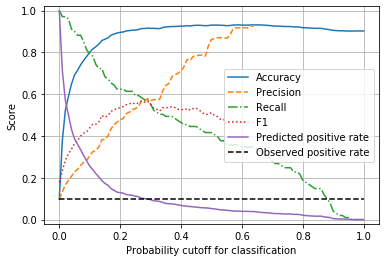

In [72]:
plot_thresholds(results)

A probability threshold of about 0.3 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [73]:
threshold = 0.3

In [74]:
results = final_random_forest(X,y)

In [75]:
# Look at accuracy
results[0]

0.9148805078416729

In [76]:
# Look at precision and recall
results[1:3]

[0.5686868686868687, 0.5536363636363636]

In [77]:
# Look at predicted positive rate
results[4]

0.09565907393577296

## Burglary

In [78]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['burglary'], bin_edges = pd.qcut(devon_cornwall['burglary'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [79]:
# Have a look at counts
devon_cornwall['burglary'].value_counts()

0    930
1    104
Name: burglary, dtype: int64

In [80]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       33.7     1

In [81]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['burglary'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [82]:
initial = initial_rf_regression(X,y)

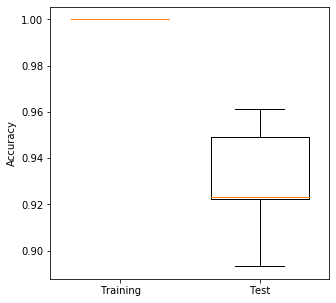

In [83]:
plot_initial_accuracy(initial)

In [84]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5  \
private_rent            0.036143  0.028576  0.035323  0.031525  0.030725   
room_rating             0.027347  0.027793  0.029025  0.035686  0.030002   
married                 0.032908  0.022517  0.028584  0.032767  0.025614   
new_eu_birth            0.024603  0.030943  0.033663  0.029347  0.028287   
flat                    0.032242  0.024362  0.023585  0.026000  0.023959   
semi_detached           0.033619  0.025404  0.022545  0.031854  0.029350   
two_plus_cars           0.021648  0.023697  0.024416  0.025089  0.023777   
wider_barriers          0.023395  0.025792  0.017356  0.027431  0.022658   
british_birth           0.016802  0.019609  0.016865  0.015158  0.015567   
divorced                0.015037  0.013524  0.011778  0.017873  0.018848   
imd                     0.010968  0.008679  0.017499  0.012039  0.012991   
mixed                   0.011872  0.012123  0.010490  0.016320  0.016651   
non_dependent_children  0.010467  0.012345  0.011515  0.011754  0.015060   
detached                0.016545  0.010294  0.017169  0.011796  0.007161   
language                0.013525  0.007190  0.010673  0.009875  0.007858   
owners                  0.009099  0.009872  0.006818  0.015389  0.010265   
health_score            0.011109  0.009830  0.005373  0.011032  0.009907   
single                  0.007184  0.008928  0.005174  0.010335  0.011333   
employment_score        0.008783  0.010062  0.012096  0.008836  0.011240   
m_25                    0.012495  0.010510  0.007480  0.011491  0.008393   
private_transport       0.008570  0.006645  0.008525  0.011394  0.013254   
white                   0.011860  0.010197  0.007095  0.005816  0.007609   
unemployment            0.008066  0.007534  0.007156  0.006708  0.007894   
idaopi                  0.007693  0.008628  0.003332  0.006602  0.005789   
income_score            0.009441  0.006432  0.006344  0.006558  0.004298   
m_27                    0.006632  0.007289  0.004685  0.007844  0.004616   
indian                  0.004136  0.008353  0.007817  0.004145  0.008556   
f_24                    0.004695  0.008707  0.006815  0.006884  0.004064   
illness                 0.006381  0.008354  0.005293  0.003779  0.005530   
outdoors_score          0.006391  0.004410  0.008134  0.005457  0.007424   

                         split_6   split_7   split_8   split_9  split_10  \
private_rent            0.036705  0.035681  0.032050  0.027240  0.024860   
room_rating             0.036601  0.041278  0.037802  0.024546  0.025757   
married                 0.026387  0.032859  0.038224  0.030841  0.025817   
new_eu_birth            0.028361  0.028488  0.033530  0.021583  0.031686   
flat                    0.038832  0.030576  0.021629  0.032552  0.029513   
semi_detached           0.034450  0.026177  0.026565  0.028532  0.023621   
two_plus_cars           0.019128  0.020152  0.026482  0.028487  0.023150   
wider_barriers          0.022670  0.019925  0.027789  0.027487  0.017261   
british_birth           0.019946  0.020097  0.013121  0.014871  0.018289   
divorced                0.017316  0.014611  0.014973  0.013932  0.013635   
imd                     0.019010  0.009973  0.019031  0.013790  0.012100   
mixed                   0.013952  0.017106  0.010694  0.011738  0.012935   
non_dependent_children  0.018690  0.014428  0.009392  0.016034  0.012951   
detached                0.013351  0.013928  0.012603  0.014860  0.014104   
language                0.015536  0.013173  0.008848  0.008195  0.013853   
owners                  0.011607  0.006518  0.011527  0.010517  0.008540   
health_score            0.010038  0.009370  0.009782  0.009592  0.009132   
single                  0.007575  0.006664  0.011562  0.011270  0.012780   
employment_score        0.009103  0.006683  0.006416  0.006658  0.010393   
m_25                    0.007867  0.006627  0.007046  0.008234  0.009340   
private_transport       0.009356  0.009177  0.005043  0.009133  0.006926

In [85]:
top_features = top_30_features(initial)

In [86]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('burglary')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('burglary',axis=1) 
y_df = feature_selected['burglary'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [87]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.4min finished


{'n_estimators': 1400,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': True}

In [88]:
best = best_rf_regression(X,y)

In [89]:
# Look at accuracies
best[0:2]

(0.9623894990933556, 0.9390963405526511)

In [90]:
# Look at ROC AUC
best[2:4]

(0.994089820848664, 0.8783186705767351)

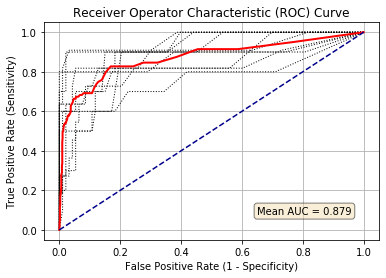

In [91]:
results = check_thresholds(X,y)

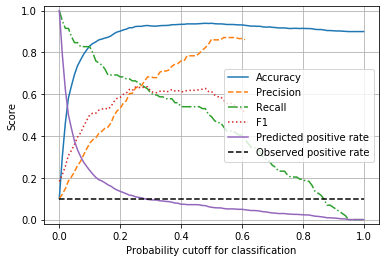

In [92]:
plot_thresholds(results)

A probability threshold of about 0.26 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [93]:
threshold = 0.26

In [94]:
results = final_random_forest(X,y)

In [95]:
# Look at accuracy
results[0]

0.9245238984316654

In [96]:
# Look at precision and recall
results[1:3]

[0.6370149295149294, 0.6536363636363636]

In [97]:
# Look at predicted positive rate
results[4]

0.10641336818521283

## Criminal damage and arson

In [98]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['damage_arson'], bin_edges = pd.qcut(devon_cornwall['damage_arson'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [99]:
# Have a look at counts
devon_cornwall['damage_arson'].value_counts()

0    931
1    103
Name: damage_arson, dtype: int64

In [100]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        1.0     0
1       88.0     1

In [101]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['damage_arson'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [102]:
initial = initial_rf_regression(X,y)

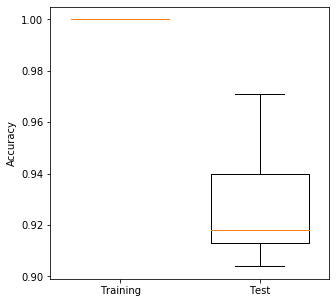

In [103]:
plot_initial_accuracy(initial)

In [104]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5  \
married                 0.034842  0.042413  0.037944  0.038182  0.040924   
two_plus_cars           0.043006  0.034268  0.031516  0.035079  0.043668   
room_rating             0.029580  0.026799  0.033302  0.031032  0.033577   
wider_barriers          0.025585  0.023969  0.024210  0.026267  0.025838   
imd                     0.035682  0.020801  0.025597  0.022786  0.028761   
idaopi                  0.022306  0.017845  0.020218  0.020761  0.018504   
owners                  0.018056  0.024297  0.020034  0.016912  0.022962   
private_rent            0.024159  0.018316  0.028064  0.029740  0.022304   
unemployment            0.017057  0.017699  0.021667  0.017498  0.013641   
flat                    0.014335  0.022703  0.015315  0.017547  0.014855   
semi_detached           0.017833  0.015557  0.016942  0.016273  0.022490   
british_birth           0.013386  0.011263  0.016316  0.014840  0.017958   
single                  0.017540  0.018009  0.010579  0.012082  0.009668   
divorced                0.016636  0.012428  0.014459  0.014449  0.013662   
employment_score        0.017135  0.013417  0.009985  0.008963  0.012540   
new_eu_birth            0.012887  0.008922  0.013287  0.012810  0.020027   
income_score            0.007931  0.012151  0.017867  0.012029  0.012314   
health_score            0.012571  0.009483  0.006802  0.010644  0.006841   
private_transport       0.006595  0.013674  0.010863  0.008739  0.009925   
mixed                   0.004023  0.012150  0.008060  0.010594  0.005111   
detached                0.008049  0.012631  0.008041  0.004973  0.010616   
language                0.009424  0.004704  0.008090  0.004727  0.009939   
m_33                    0.007904  0.006190  0.011799  0.005810  0.009002   
idaci                   0.010523  0.006964  0.006097  0.011233  0.006889   
no_children             0.010669  0.005555  0.004702  0.009183  0.005947   
illness                 0.008347  0.004878  0.007042  0.006751  0.006220   
m_all_ages              0.006327  0.008839  0.008951  0.005653  0.002143   
non_dependent_children  0.009510  0.006572  0.003000  0.009381  0.007721   
f_22                    0.004103  0.007622  0.003061  0.006855  0.003219   
alternative_transport   0.006696  0.004495  0.007616  0.007118  0.005245   

                         split_6   split_7   split_8   split_9  split_10  \
married                 0.033227  0.044123  0.039173  0.042017  0.037711   
two_plus_cars           0.035920  0.042139  0.036685  0.031498  0.049513   
room_rating             0.037087  0.032703  0.033260  0.031285  0.033616   
wider_barriers          0.027500  0.027118  0.024647  0.025071  0.030434   
imd                     0.023133  0.024916  0.025222  0.026960  0.025938   
idaopi                  0.025556  0.025435  0.023283  0.024211  0.024916   
owners                  0.024351  0.018064  0.020078  0.025409  0.022676   
private_rent            0.009383  0.018909  0.010292  0.017981  0.016278   
unemployment            0.016536  0.019572  0.022127  0.020197  0.019475   
flat                    0.016301  0.015474  0.017053  0.014061  0.017072   
semi_detached           0.012053  0.017098  0.010486  0.015662  0.017823   
british_birth           0.012440  0.015410  0.013130  0.018418  0.015947   
single                  0.016240  0.013565  0.014140  0.018208  0.016739   
divorced                0.010610  0.015253  0.009954  0.012630  0.016047   
employment_score        0.013379  0.012354  0.013628  0.017465  0.014976   
new_eu_birth            0.009466  0.013552  0.015368  0.015169  0.011681   
income_score            0.011171  0.008005  0.016071  0.011037  0.016735   
health_score            0.010373  0.009846  0.012359  0.009491  0.008425   
private_transport       0.007751  0.014325  0.007063  0.006886  0.010025   
mixed                   0.005524  0.011392  0.007051  0.012680  0.010118   
detached                0.007431  0.013875  0.007173  0.006074  0.007099

In [105]:
top_features = top_30_features(initial)

In [106]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('damage_arson')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('damage_arson',axis=1) 
y_df = feature_selected['damage_arson'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [107]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


{'n_estimators': 800,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 30,
 'bootstrap': False}

In [108]:
best = best_rf_regression(X,y)

In [109]:
# Look at accuracies
best[0:2]

(0.9937674832241896, 0.9294156086631815)

In [110]:
# Look at ROC AUC
best[2:4]

(0.9997991351017994, 0.9345992179863145)

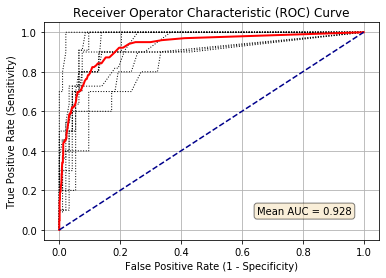

In [111]:
results = check_thresholds(X,y)

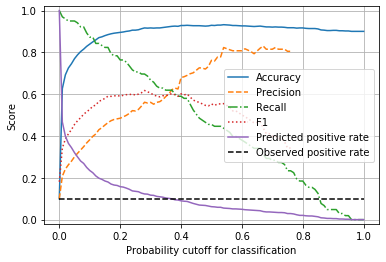

In [112]:
plot_thresholds(results)

A probability threshold of about 0.36 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [113]:
threshold = 0.36

In [114]:
results = final_random_forest(X,y)

In [115]:
# Look at accuracy
results[0]

0.9226008215085886

In [116]:
# Look at precision and recall
results[1:3]

[0.6014180264180264, 0.6190909090909091]

In [117]:
# Look at predicted positive rate
results[4]

0.10151232262882748

## Drugs

In [118]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['drugs'], bin_edges = pd.qcut(devon_cornwall['drugs'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [119]:
# Have a look at counts
devon_cornwall['drugs'].value_counts()

0    930
1    104
Name: drugs, dtype: int64

In [120]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       24.7     1

In [121]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['drugs'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [122]:
initial = initial_rf_regression(X,y)

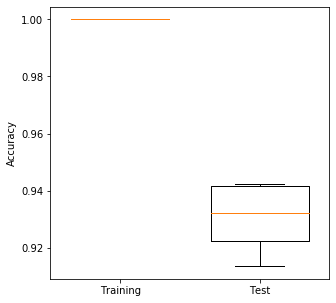

In [123]:
plot_initial_accuracy(initial)

In [124]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5  \
married                 0.042489  0.043899  0.039067  0.032256  0.038460   
room_rating             0.039147  0.033925  0.030302  0.038344  0.033896   
private_rent            0.033519  0.019707  0.022639  0.023933  0.017325   
two_plus_cars           0.018865  0.019422  0.024259  0.031279  0.024953   
mixed                   0.023470  0.021685  0.012581  0.018503  0.023418   
flat                    0.018510  0.015454  0.020267  0.017357  0.015242   
private_transport       0.019851  0.023186  0.019773  0.018395  0.016116   
wider_barriers          0.015116  0.018196  0.017835  0.018274  0.021282   
semi_detached           0.015009  0.017375  0.012434  0.011272  0.022725   
single                  0.016959  0.022315  0.013687  0.016662  0.015918   
british_birth           0.022913  0.015389  0.016630  0.017152  0.016075   
alternative_transport   0.015290  0.015256  0.021491  0.013762  0.016821   
new_eu_birth            0.013459  0.015733  0.017731  0.011806  0.017064   
divorced                0.009160  0.011290  0.014641  0.013077  0.011808   
white                   0.013341  0.010478  0.010359  0.006870  0.007642   
owners                  0.010143  0.006042  0.012527  0.016252  0.008903   
non_dependent_children  0.015182  0.007067  0.005979  0.008108  0.013872   
m_25                    0.006991  0.008821  0.006783  0.007230  0.006386   
f_23                    0.009627  0.008823  0.009145  0.011225  0.011362   
unpaid_care             0.007250  0.017357  0.007156  0.009059  0.009047   
f_21                    0.017747  0.007605  0.011522  0.008603  0.011261   
imd                     0.011542  0.007858  0.007364  0.010834  0.008072   
health_score            0.007673  0.006091  0.008215  0.007583  0.007394   
m_all_ages              0.005293  0.006164  0.011185  0.007929  0.008626   
m_24                    0.005842  0.006053  0.003339  0.008725  0.006816   
indian                  0.009084  0.009820  0.004370  0.005838  0.004814   
language                0.007985  0.005846  0.009631  0.007633  0.005687   
m_22                    0.010087  0.006849  0.006341  0.005822  0.008221   
hospitality             0.005106  0.003770  0.004698  0.006181  0.010961   
2018_population         0.006057  0.007223  0.005099  0.005450  0.005914   

                         split_6   split_7   split_8   split_9  split_10  \
married                 0.045574  0.043510  0.041931  0.044615  0.035807   
room_rating             0.034543  0.030682  0.036285  0.036959  0.031732   
private_rent            0.025608  0.030054  0.023599  0.033138  0.025824   
two_plus_cars           0.033420  0.020682  0.017233  0.028561  0.027359   
mixed                   0.025864  0.019268  0.017092  0.016778  0.022867   
flat                    0.016870  0.025749  0.022397  0.017801  0.022569   
private_transport       0.017669  0.018644  0.016726  0.019566  0.018267   
wider_barriers          0.019798  0.021691  0.016448  0.017916  0.018495   
semi_detached           0.024658  0.022672  0.018080  0.018394  0.022348   
single                  0.017656  0.017937  0.022526  0.019253  0.015253   
british_birth           0.010897  0.014460  0.014978  0.018242  0.014561   
alternative_transport   0.018801  0.012891  0.014483  0.017666  0.012047   
new_eu_birth            0.014923  0.012323  0.012169  0.008289  0.019184   
divorced                0.012873  0.010268  0.015651  0.012584  0.017914   
white                   0.008670  0.007691  0.019326  0.015754  0.008873   
owners                  0.012082  0.013415  0.010392  0.011582  0.007067   
non_dependent_children  0.012545  0.006555  0.009116  0.011142  0.012754   
m_25                    0.012425  0.009796  0.013662  0.015489  0.010300   
f_23                    0.013920  0.007838  0.011335  0.003714  0.006019   
unpaid_care             0.007154  0.010943  0.007077  0.012439  0.005105   
f_21                    0.007721  0.008571  0.006598  0.006084  0.004783

In [125]:
top_features = top_30_features(initial)

In [126]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('drugs')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('drugs',axis=1) 
y_df = feature_selected['drugs'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [127]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 80,
 'bootstrap': False}

In [128]:
best = best_rf_regression(X,y)

In [129]:
# Look at accuracies
best[0:2]

(0.9839887737777625, 0.930349141150112)

In [130]:
# Look at ROC AUC
best[2:4]

(0.999615979327199, 0.9022531769305964)

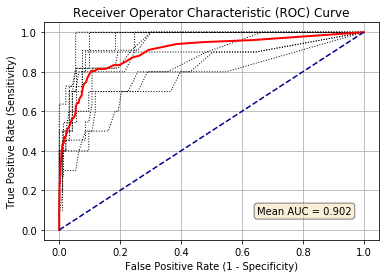

In [131]:
results = check_thresholds(X,y)

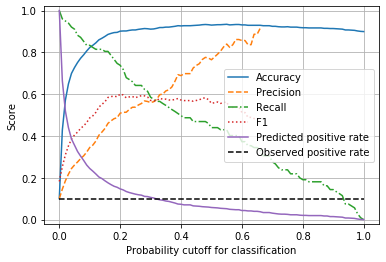

In [132]:
plot_thresholds(results)

A probability threshold of about 0.3 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [133]:
threshold = 0.3

In [134]:
results = final_random_forest(X,y)

In [135]:
# Look at accuracy
results[0]

0.9110436893203883

In [136]:
# Look at precision and recall
results[1:3]

[0.55997668997669, 0.5854545454545454]

In [137]:
# Look at predicted positive rate
results[4]

0.1063386855862584

## Other crime

In [138]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['other_crime'], bin_edges = pd.qcut(devon_cornwall['other_crime'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [139]:
# Have a look at counts
devon_cornwall['other_crime'].value_counts()

0    934
1    100
Name: other_crime, dtype: int64

In [140]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       13.0     1

In [141]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['other_crime'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [142]:
initial = initial_rf_regression(X,y)

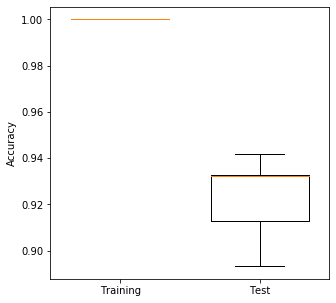

In [143]:
plot_initial_accuracy(initial)

In [144]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5   split_6  \
two_plus_cars     0.026934  0.032570  0.033661  0.031080  0.026391  0.035778   
imd               0.026996  0.015229  0.024630  0.021852  0.027117  0.018555   
married           0.019085  0.018590  0.021758  0.023828  0.019031  0.024669   
unemployment      0.018705  0.013850  0.015416  0.015783  0.014535  0.020715   
semi_detached     0.010663  0.017747  0.023387  0.012282  0.015394  0.019801   
owners            0.016947  0.014386  0.017176  0.017160  0.020673  0.015847   
wider_barriers    0.016461  0.010883  0.017142  0.018704  0.011014  0.017611   
new_eu_birth      0.012273  0.018061  0.013985  0.017038  0.015058  0.019324   
idaopi            0.012549  0.011600  0.010480  0.013831  0.012204  0.015790   
employment_score  0.013475  0.014231  0.015017  0.012174  0.012298  0.013914   
health_score      0.012959  0.012192  0.011828  0.012623  0.012216  0.016141   
single            0.009647  0.012805  0.015118  0.010934  0.011401  0.012675   
room_rating       0.012777  0.007908  0.015564  0.010947  0.017475  0.015888   
income_score      0.012719  0.013995  0.007283  0.013694  0.010798  0.013919   
detached          0.011710  0.012185  0.007887  0.006587  0.009185  0.014808   
flat              0.011283  0.009415  0.009809  0.010099  0.016536  0.011427   
language          0.007060  0.009040  0.009756  0.012815  0.010490  0.017054   
black             0.012325  0.007248  0.008624  0.011261  0.010501  0.012577   
british_birth     0.008840  0.012319  0.006677  0.011519  0.011149  0.007626   
m_33              0.006643  0.008289  0.011649  0.009497  0.007859  0.008585   
public_transport  0.013749  0.010231  0.009282  0.007163  0.005818  0.007903   
bangladeshi       0.008864  0.011397  0.007130  0.005815  0.006111  0.008980   
divorced          0.006518  0.004835  0.008272  0.011848  0.012207  0.010639   
outdoors_score    0.011767  0.005998  0.006173  0.008404  0.006885  0.007094   
m_29              0.010351  0.008007  0.011012  0.008701  0.007346  0.006433   
idaci             0.005390  0.007293  0.009796  0.005432  0.010118  0.010740   
unpaid_care       0.008438  0.007513  0.006901  0.008438  0.007645  0.006115   
m_25              0.006536  0.008114  0.005732  0.008363  0.005340  0.008215   
education_score   0.006651  0.006961  0.006806  0.009090  0.002021  0.006531   
illness           0.005359  0.009129  0.004845  0.005234  0.009452  0.005531   

                   split_7   split_8   split_9  split_10      mean  
two_plus_cars     0.022027  0.037266  0.028976  0.031255  0.030594  
imd               0.018106  0.019927  0.023403  0.025469  0.022128  
married           0.020317  0.022370  0.024164  0.020107  0.021392  
unemployment      0.013870  0.018203  0.014785  0.018742  0.016460  
semi_detached     0.018971  0.011000  0.017508  0.016078  0.016283  
owners            0.016947  0.013534  0.014125  0.014159  0.016095  
wider_barriers    0.011567  0.019719  0.016310  0.018105  0.015752  
new_eu_birth      0.015030  0.016027  0.015015  0.009878  0.015169  
idaopi            0.012375  0.016900  0.019529  0.016270  0.014153  
employment_score  0.011499  0.013817  0.015826  0.017920  0.014017  
health_score      0.016389  0.013179  0.014588  0.015583  0.013770  
single            0.018194  0.017127  0.013266  0.015726  0.013689  
room_rating       0.008761  0.016352  0.012172  0.009568  0.012741  
income_score      0.008810  0.018002  0.012958  0.012296  0.012447  
detached          0.018080  0.008904  0.010312  0.014682  0.011434  
flat              0.008866  0.013942  0.010735  0.010564  0.011268  
language          0.010307  0.012366  0.007221  0.006988  0.010310  
black             0.008495  0.008238  0.010912  0.008236  0.009842  
british_birth     0.008691  0.009508  0.009230  0.012104  0.009766  
m_33              0.014947  0.014124  0.005796  0.010122  0.009751  
public_transport  0.013603  0.009641  0.007616  0.007714  0.009272  
bangladeshi       0.

In [145]:
top_features = top_30_features(initial)

In [146]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('other_crime')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('other_crime',axis=1) 
y_df = feature_selected['other_crime'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [147]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.1min finished


{'n_estimators': 600,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 110,
 'bootstrap': True}

In [148]:
best = best_rf_regression(X,y)

In [149]:
# Look at accuracies
best[0:2]

(0.9714158668560804, 0.9264563106796118)

In [150]:
# Look at ROC AUC
best[2:4]

(0.9987257658116754, 0.8699611072981013)

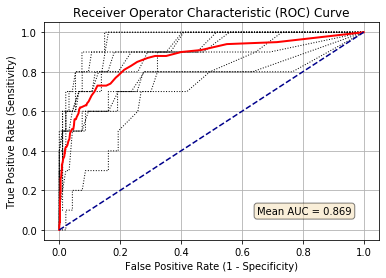

In [151]:
results = check_thresholds(X,y)

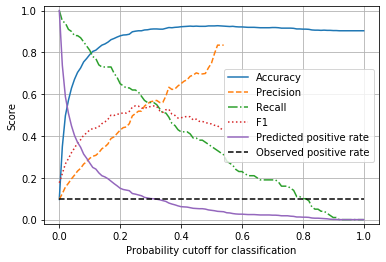

In [152]:
plot_thresholds(results)

A probability threshold of about 0.3 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [153]:
threshold = 0.3

In [154]:
results = final_random_forest(X,y)

In [155]:
# Look at accuracy
results[0]

0.910969006721434

In [156]:
# Look at precision and recall
results[1:3]

[0.5638439338439338, 0.5599999999999999]

In [157]:
# Look at predicted positive rate
results[4]

0.10058812546676624

## Other theft

In [158]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['other_theft'], bin_edges = pd.qcut(devon_cornwall['other_theft'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [159]:
# Have a look at counts
devon_cornwall['other_theft'].value_counts()

0    930
1    104
Name: other_theft, dtype: int64

In [160]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        1.0     0
1       62.7     1

In [161]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['other_theft'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [162]:
initial = initial_rf_regression(X,y)

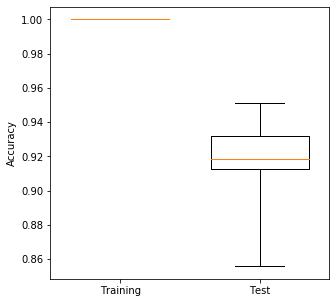

In [163]:
plot_initial_accuracy(initial)

In [164]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5  \
two_plus_cars           0.033030  0.028705  0.029761  0.030461  0.030037   
room_rating             0.036484  0.027805  0.027989  0.031660  0.025036   
married                 0.023781  0.018905  0.016534  0.018116  0.018536   
flat                    0.024227  0.016484  0.023972  0.022962  0.015198   
new_eu_birth            0.016431  0.023965  0.022212  0.019919  0.022335   
semi_detached           0.017034  0.014960  0.019525  0.015025  0.015702   
private_rent            0.023549  0.012496  0.017833  0.019015  0.014915   
british_birth           0.014164  0.010414  0.014094  0.020557  0.015021   
language                0.011686  0.013502  0.014417  0.012374  0.011130   
m_33                    0.012887  0.010787  0.014208  0.014053  0.012926   
mixed                   0.015626  0.012101  0.008950  0.012086  0.010069   
owners                  0.010215  0.006140  0.012723  0.011537  0.011946   
divorced                0.015198  0.008876  0.007358  0.016542  0.012117   
private_transport       0.008955  0.009932  0.013087  0.008999  0.011108   
non_dependent_children  0.013125  0.011386  0.015856  0.006109  0.015269   
m_25                    0.012496  0.008290  0.006105  0.008935  0.008015   
wider_barriers          0.009475  0.006573  0.006363  0.010370  0.009260   
alternative_transport   0.006760  0.007811  0.007918  0.004611  0.015089   
idaopi                  0.009518  0.008111  0.009114  0.010543  0.010523   
imd                     0.008593  0.007505  0.007798  0.005978  0.006388   
single                  0.007758  0.006896  0.006361  0.009060  0.008204   
illness                 0.007823  0.006883  0.006618  0.007592  0.010331   
hospitality             0.009013  0.007856  0.007421  0.008775  0.008014   
f_23                    0.008992  0.007641  0.010065  0.004349  0.005498   
employment_score        0.008048  0.008181  0.005379  0.008649  0.007162   
chinese                 0.004925  0.010279  0.007235  0.005410  0.008697   
income_score            0.007527  0.004957  0.007903  0.008123  0.007147   
f_24                    0.009049  0.006469  0.010245  0.006219  0.006654   
m_24                    0.007419  0.008734  0.006840  0.006740  0.003748   
white                   0.003751  0.008667  0.007818  0.005740  0.008964   

                         split_6   split_7   split_8   split_9  split_10  \
two_plus_cars           0.033941  0.028532  0.033331  0.024605  0.036036   
room_rating             0.032565  0.032277  0.027541  0.023826  0.023458   
married                 0.024793  0.025988  0.018911  0.023809  0.025614   
flat                    0.015385  0.017975  0.023064  0.022354  0.015479   
new_eu_birth            0.022448  0.007745  0.019985  0.015873  0.019046   
semi_detached           0.018965  0.016375  0.014164  0.017150  0.011663   
private_rent            0.014194  0.015781  0.011039  0.017667  0.013764   
british_birth           0.013069  0.015067  0.018614  0.012128  0.016427   
language                0.015121  0.010352  0.013989  0.012353  0.013140   
m_33                    0.012980  0.006798  0.008099  0.013856  0.016788   
mixed                   0.012765  0.015708  0.013621  0.012113  0.010072   
owners                  0.014425  0.012012  0.008653  0.012426  0.010317   
divorced                0.008964  0.009215  0.010340  0.011973  0.008598   
private_transport       0.010763  0.009979  0.012197  0.010068  0.010931   
non_dependent_children  0.009033  0.006012  0.006254  0.011632  0.009518   
m_25                    0.008974  0.013247  0.014399  0.011804  0.006065   
wider_barriers          0.013110  0.012896  0.009918  0.007837  0.007512   
alternative_transport   0.009932  0.007677  0.007111  0.010677  0.012953   
idaopi                  0.007705  0.005677  0.008687  0.011651  0.006492   
imd                     0.009867  0.011143  0.010570  0.009819  0.006877   
single                  0.010719  0.007660  0.008545  0.008564  0.006014

In [165]:
top_features = top_30_features(initial)

In [166]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('other_theft')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('other_theft',axis=1) 
y_df = feature_selected['other_theft'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [167]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished


{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 20,
 'bootstrap': True}

In [168]:
best = best_rf_regression(X,y)

In [169]:
# Look at accuracies
best[0:2]

(1.0, 0.9284727408513817)

In [170]:
# Look at ROC AUC
best[2:4]

(1.0, 0.8512463343108504)

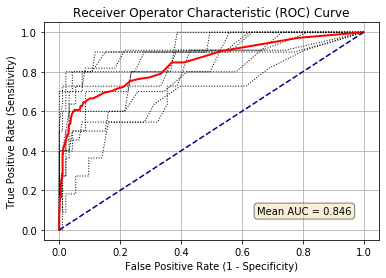

In [171]:
results = check_thresholds(X,y)

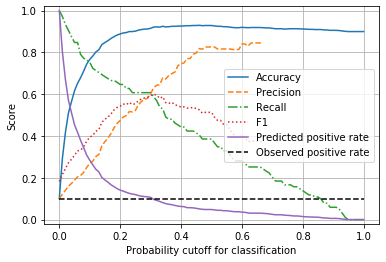

In [172]:
plot_thresholds(results)

A probability threshold of about 0.3 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [173]:
threshold = 0.3

In [174]:
results = final_random_forest(X,y)

In [175]:
# Look at accuracy
results[0]

0.9149551904406273

In [176]:
# Look at precision and recall
results[1:3]

[0.6020344129554656, 0.6072727272727272]

In [177]:
# Look at predicted positive rate
results[4]

0.10634802091112769

## Possession of weapons

In [178]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['possession_weapons'], bin_edges = pd.qcut(devon_cornwall['possession_weapons'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [179]:
# Have a look at counts
devon_cornwall['possession_weapons'].value_counts()

0    941
1     93
Name: possession_weapons, dtype: int64

In [180]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        6.0     1

In [181]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['possession_weapons'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [182]:
initial = initial_rf_regression(X,y)

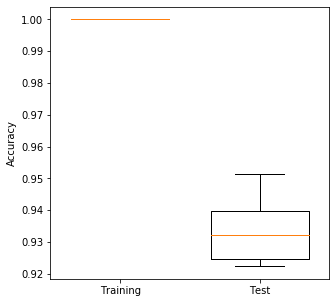

In [183]:
plot_initial_accuracy(initial)

In [184]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5  \
married                 0.033388  0.033422  0.030112  0.032859  0.034046   
two_plus_cars           0.023237  0.038932  0.032864  0.027546  0.029533   
room_rating             0.028044  0.023779  0.031123  0.036906  0.027600   
private_rent            0.030708  0.021761  0.025690  0.023414  0.029684   
flat                    0.022237  0.015904  0.020639  0.022217  0.017359   
new_eu_birth            0.022787  0.018469  0.025503  0.019736  0.021031   
owners                  0.017481  0.020706  0.014673  0.018177  0.021134   
wider_barriers          0.019663  0.019548  0.022650  0.019178  0.025562   
british_birth           0.018977  0.015596  0.015524  0.019017  0.020301   
semi_detached           0.014030  0.018484  0.019856  0.011731  0.016253   
imd                     0.015754  0.011666  0.012159  0.012687  0.012182   
mixed                   0.009048  0.018472  0.015041  0.012521  0.013553   
divorced                0.017178  0.010769  0.015993  0.017104  0.009266   
single                  0.014080  0.015642  0.013889  0.011567  0.013066   
private_transport       0.010629  0.014203  0.007398  0.011700  0.012937   
idaopi                  0.007932  0.010914  0.006129  0.010549  0.011857   
f_22                    0.009838  0.010531  0.014776  0.010056  0.007831   
language                0.008921  0.008044  0.012666  0.008770  0.010309   
health_score            0.009530  0.006195  0.010673  0.010670  0.009524   
alternative_transport   0.006275  0.010293  0.013818  0.010925  0.009702   
education_score         0.010793  0.010630  0.007731  0.008382  0.009514   
white                   0.009806  0.007845  0.006109  0.004710  0.011733   
employment_score        0.008112  0.008128  0.008151  0.009674  0.009443   
non_dependent_children  0.008256  0.008694  0.009238  0.007252  0.007485   
chinese                 0.009180  0.007846  0.007124  0.007306  0.009894   
income_score            0.010482  0.007123  0.005267  0.009584  0.004850   
children_score          0.011525  0.005673  0.004915  0.006026  0.011764   
unemployment            0.004812  0.005904  0.005668  0.010446  0.009194   
black                   0.005826  0.011056  0.004746  0.007830  0.005020   
indian                  0.006368  0.004108  0.008501  0.008531  0.007780   

                         split_6   split_7   split_8   split_9  split_10  \
married                 0.028941  0.032405  0.039655  0.034626  0.031086   
two_plus_cars           0.035225  0.033482  0.016775  0.035969  0.031090   
room_rating             0.029242  0.032997  0.026432  0.039241  0.026474   
private_rent            0.022633  0.024001  0.034747  0.029096  0.027378   
flat                    0.020107  0.019981  0.023706  0.030685  0.016841   
new_eu_birth            0.016520  0.020437  0.022370  0.020252  0.020978   
owners                  0.021534  0.023279  0.025541  0.014601  0.022887   
wider_barriers          0.016566  0.017216  0.018232  0.019313  0.021702   
british_birth           0.015725  0.014571  0.019005  0.025673  0.019336   
semi_detached           0.017053  0.017355  0.008824  0.012760  0.015014   
imd                     0.020602  0.020362  0.010030  0.015980  0.016047   
mixed                   0.014197  0.013914  0.014822  0.012114  0.022092   
divorced                0.012868  0.013933  0.013984  0.015089  0.007938   
single                  0.009503  0.013137  0.012023  0.008103  0.019495   
private_transport       0.015389  0.010273  0.018736  0.013034  0.008708   
idaopi                  0.009230  0.014914  0.015818  0.010498  0.009045   
f_22                    0.010157  0.008592  0.011037  0.009883  0.010232   
language                0.007578  0.007058  0.011917  0.012059  0.014113   
health_score            0.010955  0.009793  0.008700  0.009019  0.012854   
alternative_transport   0.007749  0.007901  0.009530  0.008095  0.008903   
education_score         0.006999  0.008036  0.006686  0.011773  0.011423

In [185]:
top_features = top_30_features(initial)

In [186]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('possession_weapons')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('possession_weapons',axis=1) 
y_df = feature_selected['possession_weapons'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [187]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.1s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 90,
 'bootstrap': False}

In [188]:
best = best_rf_regression(X,y)

In [189]:
# Look at accuracies
best[0:2]

(1.0, 0.9410194174757283)

In [190]:
# Look at ROC AUC
best[2:4]

(1.0, 0.8978188378748287)

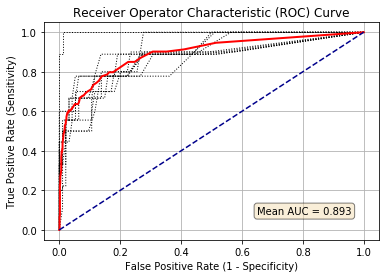

In [191]:
results = check_thresholds(X,y)

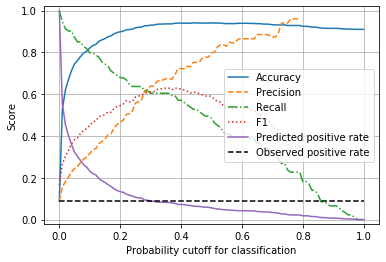

In [192]:
plot_thresholds(results)

A probability threshold of about 0.28 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [193]:
threshold = 0.28

In [194]:
results = final_random_forest(X,y)

In [195]:
# Look at accuracy
results[0]

0.9265216579536968

In [196]:
# Look at precision and recall
results[1:3]

[0.6142732267732269, 0.6155555555555556]

In [197]:
# Look at predicted positive rate
results[4]

0.09383868558625838

## Public order offences

In [198]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['public_order'], bin_edges = pd.qcut(devon_cornwall['public_order'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [199]:
# Have a look at counts
devon_cornwall['public_order'].value_counts()

0    932
1    102
Name: public_order, dtype: int64

In [200]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       40.0     1

In [201]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['public_order'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [202]:
initial = initial_rf_regression(X,y)

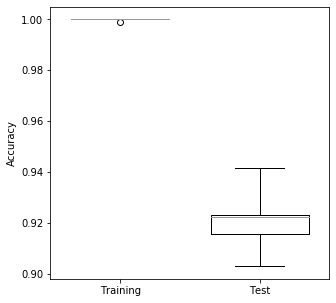

In [203]:
plot_initial_accuracy(initial)

In [204]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5  \
two_plus_cars           0.039684  0.038890  0.030475  0.031075  0.035168   
married                 0.021341  0.024223  0.024795  0.017333  0.023875   
idaopi                  0.030140  0.022941  0.021053  0.024755  0.020229   
room_rating             0.025397  0.021580  0.021322  0.025138  0.023040   
owners                  0.021921  0.022800  0.022904  0.018147  0.027972   
flat                    0.019054  0.022286  0.017307  0.020527  0.022566   
private_rent            0.019922  0.019751  0.014353  0.019148  0.023469   
wider_barriers          0.016614  0.011881  0.022194  0.015889  0.017473   
imd                     0.017538  0.010292  0.019772  0.009357  0.012842   
divorced                0.011149  0.013142  0.015202  0.017712  0.017031   
british_birth           0.009306  0.012320  0.011304  0.012232  0.010343   
private_transport       0.012518  0.011888  0.016131  0.005823  0.009926   
unemployment            0.011333  0.011508  0.014871  0.007256  0.011124   
employment_score        0.010042  0.009450  0.009396  0.010303  0.009989   
health_score            0.009642  0.008715  0.008985  0.008111  0.012685   
non_dependent_children  0.009596  0.014821  0.007912  0.010141  0.007686   
new_eu_birth            0.010651  0.007908  0.005170  0.009458  0.012090   
semi_detached           0.006853  0.009401  0.007129  0.009447  0.006942   
income_score            0.009239  0.007918  0.006518  0.013421  0.009494   
alternative_transport   0.008131  0.005969  0.012146  0.007353  0.007211   
mixed                   0.007457  0.009037  0.005546  0.009709  0.010336   
illness                 0.010706  0.010383  0.006919  0.008520  0.006650   
m_25                    0.006118  0.006744  0.007763  0.009816  0.013548   
white                   0.005532  0.010552  0.004112  0.007319  0.004465   
no_children             0.006906  0.006718  0.008718  0.007536  0.004879   
f_23                    0.005280  0.006553  0.008067  0.010516  0.003512   
single                  0.009687  0.007880  0.006634  0.004366  0.003556   
m_33                    0.005993  0.006447  0.005460  0.006236  0.002371   
education_score         0.004755  0.005317  0.007655  0.006351  0.004981   
geographical_barriers   0.007745  0.003754  0.008129  0.005851  0.003960   

                         split_6   split_7   split_8   split_9  split_10  \
two_plus_cars           0.037676  0.040194  0.039830  0.036142  0.029691   
married                 0.027117  0.026184  0.025213  0.020788  0.025971   
idaopi                  0.015936  0.015762  0.025283  0.027134  0.019128   
room_rating             0.020274  0.020571  0.020815  0.016813  0.020478   
owners                  0.022773  0.026182  0.019445  0.014583  0.018202   
flat                    0.017215  0.024557  0.016200  0.027103  0.016652   
private_rent            0.013364  0.017044  0.016853  0.018027  0.016254   
wider_barriers          0.019802  0.018557  0.013929  0.017304  0.018094   
imd                     0.018615  0.012814  0.016815  0.019468  0.016572   
divorced                0.009882  0.016669  0.016495  0.011468  0.011362   
british_birth           0.009626  0.015134  0.013928  0.012012  0.013308   
private_transport       0.006967  0.014782  0.013572  0.012188  0.010333   
unemployment            0.010923  0.011970  0.010198  0.007587  0.009077   
employment_score        0.012728  0.005307  0.014658  0.009758  0.009865   
health_score            0.011498  0.008286  0.010682  0.009957  0.007743   
non_dependent_children  0.014222  0.008498  0.006137  0.009498  0.007757   
new_eu_birth            0.005176  0.015053  0.008527  0.012335  0.006978   
semi_detached           0.012817  0.006443  0.006150  0.011591  0.011995   
income_score            0.011097  0.008818  0.005660  0.007869  0.007054   
alternative_transport   0.005544  0.011804  0.010975  0.008845  0.007273   
mixed                   0.006461  0.011658  0.009892  0.007166  0.007351

In [205]:
top_features = top_30_features(initial)

In [206]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('public_order')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('public_order',axis=1) 
y_df = feature_selected['public_order'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [207]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.7s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


{'n_estimators': 400,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 100,
 'bootstrap': True}

In [208]:
best = best_rf_regression(X,y)

In [209]:
# Look at accuracies
best[0:2]

(0.9972061490130857, 0.9225821508588499)

In [210]:
# Look at ROC AUC
best[2:4]

(0.9999986902251503, 0.8894397995050018)

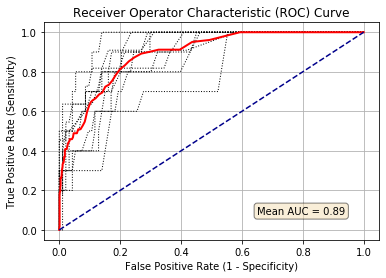

In [211]:
results = check_thresholds(X,y)

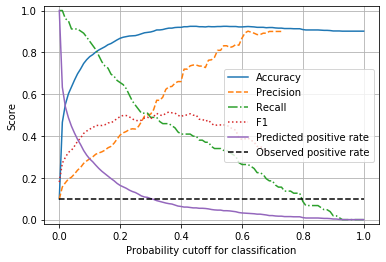

In [212]:
plot_thresholds(results)

A probability threshold of about 0.3 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [213]:
threshold = 0.3

In [214]:
results = final_random_forest(X,y)

In [215]:
# Look at accuracy
results[0]

0.8974981329350262

In [216]:
# Look at precision and recall
results[1:3]

[0.5043205405705405, 0.4890909090909091]

In [217]:
# Look at predicted positive rate
results[4]

0.10057879014189693

## Robbery

In [218]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['robbery'], bin_edges = pd.qcut(devon_cornwall['robbery'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [219]:
# Have a look at counts
devon_cornwall['robbery'].value_counts()

0    941
1     93
Name: robbery, dtype: int64

In [220]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        4.0     1

In [221]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['robbery'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [222]:
initial = initial_rf_regression(X,y)

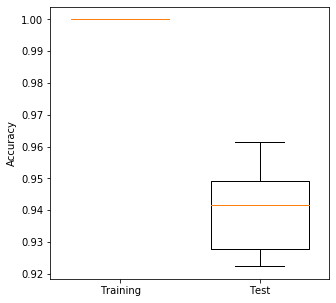

In [223]:
plot_initial_accuracy(initial)

In [224]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5  \
married                 0.046569  0.045747  0.044395  0.050230  0.039947   
room_rating             0.033599  0.035790  0.036423  0.037759  0.044176   
two_plus_cars           0.035309  0.035283  0.033414  0.041482  0.031779   
private_rent            0.036009  0.036269  0.032896  0.023113  0.032686   
semi_detached           0.031048  0.029451  0.028997  0.025312  0.020728   
new_eu_birth            0.028779  0.022066  0.030496  0.023673  0.021191   
flat                    0.027609  0.023061  0.020326  0.024285  0.020085   
detached                0.022611  0.030425  0.014944  0.026222  0.015098   
wider_barriers          0.015934  0.013119  0.020205  0.021590  0.020146   
divorced                0.017941  0.019557  0.015756  0.019397  0.015364   
language                0.014194  0.022150  0.020478  0.009047  0.017867   
owners                  0.018851  0.013852  0.016948  0.011552  0.020776   
british_birth           0.015205  0.013368  0.016553  0.016091  0.014420   
non_dependent_children  0.013113  0.013757  0.015781  0.019090  0.015967   
imd                     0.010487  0.008372  0.015285  0.011051  0.020519   
mixed                   0.017165  0.016374  0.013918  0.014408  0.012497   
unpaid_care             0.010362  0.010454  0.020359  0.015697  0.011646   
private_transport       0.011528  0.011384  0.009262  0.017451  0.015053   
employment_score        0.013405  0.013830  0.010454  0.008354  0.016137   
single                  0.012529  0.016150  0.012647  0.008834  0.018614   
m_25                    0.011815  0.012212  0.007635  0.010799  0.009371   
alternative_transport   0.007546  0.012195  0.010750  0.010405  0.011189   
health_score            0.009398  0.015811  0.010998  0.004471  0.010944   
old_eu_birth            0.004736  0.010694  0.005139  0.008399  0.013288   
chinese                 0.008722  0.011008  0.010138  0.006394  0.012070   
f_24                    0.008099  0.007447  0.009384  0.008060  0.009088   
unemployment            0.003987  0.006462  0.006542  0.007201  0.005635   
white                   0.009036  0.009472  0.004776  0.012660  0.003432   
income_score            0.004884  0.005481  0.005967  0.005858  0.008047   
idaopi                  0.010795  0.006077  0.004405  0.002819  0.005702   

                         split_6   split_7   split_8   split_9  split_10  \
married                 0.047328  0.047450  0.045157  0.051051  0.047226   
room_rating             0.035862  0.044108  0.043582  0.039482  0.049992   
two_plus_cars           0.038297  0.044395  0.037569  0.051222  0.034691   
private_rent            0.032716  0.026714  0.037006  0.024811  0.027372   
semi_detached           0.026172  0.033255  0.031889  0.023184  0.023640   
new_eu_birth            0.023659  0.028976  0.032609  0.027360  0.020835   
flat                    0.026412  0.022125  0.025930  0.021339  0.025844   
detached                0.027669  0.023736  0.020289  0.027784  0.018663   
wider_barriers          0.016347  0.014918  0.018850  0.020098  0.024738   
divorced                0.015371  0.011927  0.019388  0.023115  0.012869   
language                0.009652  0.018576  0.022661  0.015997  0.018027   
owners                  0.018944  0.014897  0.014693  0.014398  0.014555   
british_birth           0.018612  0.016242  0.017914  0.010988  0.015899   
non_dependent_children  0.015242  0.015220  0.015844  0.013420  0.014719   
imd                     0.018781  0.013415  0.014519  0.019284  0.014720   
mixed                   0.013719  0.013148  0.012550  0.012773  0.017206   
unpaid_care             0.013839  0.010770  0.016989  0.011028  0.015355   
private_transport       0.016657  0.019790  0.008795  0.009414  0.014402   
employment_score        0.009621  0.008244  0.012215  0.012737  0.011074   
single                  0.006564  0.008025  0.007551  0.012247  0.009341   
m_25                    0.009806  0.009542  0.009254  0.009908  0.012748

In [225]:
top_features = top_30_features(initial)

In [226]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('robbery')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('robbery',axis=1) 
y_df = feature_selected['robbery'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [227]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.0min finished


{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 10,
 'bootstrap': True}

In [228]:
best = best_rf_regression(X,y)

In [229]:
# Look at accuracies
best[0:2]

(0.9738880611667418, 0.9458271097834204)

In [230]:
# Look at ROC AUC
best[2:4]

(0.9947366890030193, 0.9322072912778401)

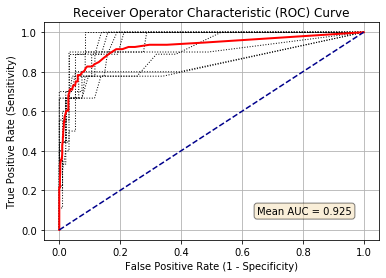

In [231]:
results = check_thresholds(X,y)

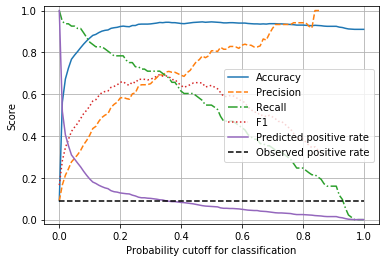

In [232]:
plot_thresholds(results)

A probability threshold of about 0.35 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [233]:
threshold = 0.35

In [234]:
results = final_random_forest(X,y)

In [235]:
# Look at accuracy
results[0]

0.943885362210605

In [236]:
# Look at precision and recall
results[1:3]

[0.7060178710178711, 0.6877777777777778]

In [237]:
# Look at predicted positive rate
results[4]

0.08995519044062732

## Shoplifting

In [238]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['shoplifting'], bin_edges = pd.qcut(devon_cornwall['shoplifting'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [239]:
# Have a look at counts
devon_cornwall['shoplifting'].value_counts()

0    930
1    104
Name: shoplifting, dtype: int64

In [240]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       58.7     1

In [241]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['shoplifting'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [242]:
initial = initial_rf_regression(X,y)

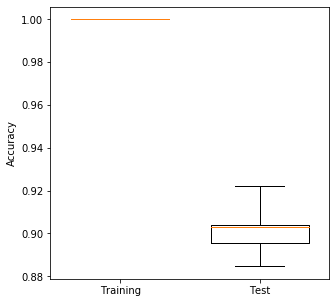

In [243]:
plot_initial_accuracy(initial)

In [244]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5  \
two_plus_cars           0.023106  0.021137  0.022148  0.019186  0.023808   
private_rent            0.024316  0.025588  0.021824  0.016084  0.019988   
new_eu_birth            0.018947  0.022099  0.021619  0.023978  0.016219   
flat                    0.016413  0.017771  0.019656  0.014114  0.020913   
room_rating             0.013693  0.020442  0.019219  0.015543  0.016905   
divorced                0.020342  0.015508  0.014825  0.015029  0.015024   
unemployment            0.013483  0.011693  0.015234  0.015953  0.011163   
british_birth           0.013732  0.012108  0.012409  0.016505  0.015991   
owners                  0.010744  0.010118  0.008227  0.010987  0.014756   
idaopi                  0.011662  0.009328  0.007639  0.008869  0.010709   
language                0.008417  0.008994  0.012741  0.009562  0.009264   
married                 0.013219  0.009663  0.008092  0.008147  0.011340   
imd                     0.009391  0.008078  0.009538  0.008865  0.008882   
wider_barriers          0.012888  0.010634  0.011740  0.007821  0.008228   
semi_detached           0.014038  0.004723  0.006993  0.005877  0.007173   
alternative_transport   0.008858  0.007871  0.010329  0.011195  0.006414   
employment_score        0.010123  0.006381  0.009773  0.006429  0.007369   
non_dependent_children  0.010300  0.008990  0.007690  0.006956  0.010045   
illness                 0.010858  0.005672  0.009240  0.009736  0.007064   
income_score            0.006163  0.005746  0.005515  0.008143  0.006191   
m_50                    0.005208  0.005858  0.004136  0.006408  0.006420   
f_13                    0.008031  0.005513  0.006590  0.005461  0.008783   
single                  0.009149  0.005862  0.005467  0.005845  0.005712   
no_children             0.004762  0.005281  0.004529  0.005768  0.010562   
private_transport       0.005340  0.007642  0.008208  0.009126  0.005080   
idaci                   0.004432  0.006437  0.005605  0.006329  0.007150   
education_score         0.006170  0.003212  0.006496  0.008120  0.006921   
m_33                    0.005784  0.008815  0.004721  0.005439  0.003227   
mixed                   0.004257  0.005869  0.005500  0.004819  0.004987   
m_48                    0.006768  0.003586  0.005023  0.007981  0.002755   

                         split_6   split_7   split_8   split_9  split_10  \
two_plus_cars           0.021822  0.017850  0.020599  0.021836  0.019640   
private_rent            0.017747  0.017321  0.023238  0.020631  0.023056   
new_eu_birth            0.018277  0.016087  0.016471  0.020052  0.025224   
flat                    0.013284  0.015031  0.020353  0.016074  0.015874   
room_rating             0.013303  0.017385  0.015395  0.016315  0.017038   
divorced                0.015376  0.019543  0.019666  0.012521  0.014460   
unemployment            0.015526  0.013537  0.017698  0.013762  0.014346   
british_birth           0.009769  0.011509  0.008467  0.011999  0.013048   
owners                  0.009850  0.011706  0.011001  0.013068  0.014253   
idaopi                  0.012801  0.009632  0.016741  0.013608  0.008870   
language                0.009980  0.011851  0.007305  0.009919  0.015385   
married                 0.010112  0.011324  0.007110  0.008634  0.010348   
imd                     0.007399  0.012889  0.009985  0.010456  0.009026   
wider_barriers          0.009185  0.007927  0.009644  0.007050  0.009243   
semi_detached           0.009530  0.005801  0.014557  0.008074  0.013596   
alternative_transport   0.007155  0.009177  0.009458  0.005649  0.011066   
employment_score        0.008718  0.006060  0.008747  0.010380  0.009939   
non_dependent_children  0.009699  0.008095  0.006286  0.008055  0.005721   
illness                 0.006271  0.006968  0.006108  0.005993  0.006275   
income_score            0.007751  0.007017  0.007032  0.006632  0.005633   
m_50                    0.007410  0.008204  0.007589  0.008073  0.006058

In [245]:
top_features = top_30_features(initial)

In [246]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('shoplifting')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('shoplifting',axis=1) 
y_df = feature_selected['shoplifting'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [247]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   18.4s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  3.1min finished


{'n_estimators': 200,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'sqrt',
 'max_depth': 50,
 'bootstrap': True}

In [248]:
best = best_rf_regression(X,y)

In [249]:
# Look at accuracies
best[0:2]

(1.0, 0.905227781926811)

In [250]:
# Look at ROC AUC
best[2:4]

(1.0, 0.8096823069403716)

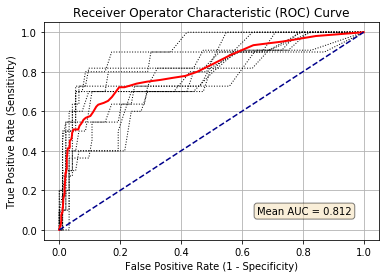

In [251]:
results = check_thresholds(X,y)

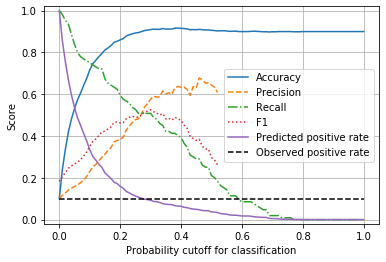

In [252]:
plot_thresholds(results)

A probability threshold of about 0.26 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [253]:
threshold = 0.26

In [254]:
results = final_random_forest(X,y)

In [255]:
# Look at accuracy
results[0]

0.8946041822255415

In [256]:
# Look at precision and recall
results[1:3]

[0.48202020202020196, 0.5081818181818182]

In [257]:
# Look at predicted positive rate
results[4]

0.10730022404779685

## Theft from the person

In [258]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['theft_person'], bin_edges = pd.qcut(devon_cornwall['theft_person'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [259]:
# Have a look at counts
devon_cornwall['theft_person'].value_counts()

0    934
1    100
Name: theft_person, dtype: int64

In [260]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1        5.0     1

In [261]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['theft_person'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [262]:
initial = initial_rf_regression(X,y)

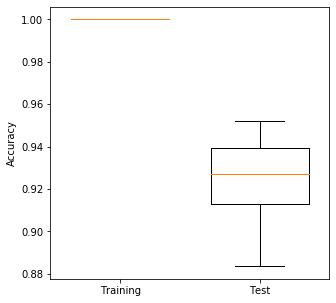

In [263]:
plot_initial_accuracy(initial)

In [264]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5  \
private_rent            0.039488  0.038203  0.046873  0.048038  0.035506   
room_rating             0.035998  0.040769  0.032494  0.029809  0.024681   
flat                    0.034574  0.036056  0.033807  0.026970  0.026247   
married                 0.021608  0.028394  0.026399  0.021497  0.024138   
semi_detached           0.025427  0.018585  0.022476  0.024242  0.027026   
two_plus_cars           0.026477  0.024376  0.021800  0.019608  0.022087   
british_birth           0.017493  0.017320  0.018384  0.019837  0.019065   
non_dependent_children  0.010779  0.017959  0.018323  0.021890  0.019443   
private_transport       0.014892  0.012876  0.019435  0.010411  0.018522   
new_eu_birth            0.021364  0.016014  0.009975  0.009681  0.013409   
mixed                   0.010428  0.013331  0.011688  0.008590  0.013787   
white                   0.011509  0.009304  0.011586  0.014017  0.012420   
owners                  0.011132  0.019814  0.010937  0.013920  0.010885   
indian                  0.011049  0.010763  0.014296  0.014116  0.013091   
divorced                0.013256  0.008659  0.014132  0.013535  0.016682   
wider_barriers          0.011030  0.012513  0.011031  0.013899  0.013166   
alternative_transport   0.010441  0.008079  0.014088  0.011328  0.011321   
chinese                 0.011230  0.008185  0.008271  0.009219  0.008323   
m_25                    0.006845  0.008407  0.005606  0.009096  0.013066   
unpaid_care             0.006368  0.006948  0.014499  0.008703  0.006595   
language                0.010920  0.006996  0.009562  0.009452  0.010762   
single                  0.007629  0.012575  0.008306  0.007159  0.005708   
idaopi                  0.005574  0.007267  0.008723  0.007770  0.007265   
f_24                    0.006829  0.005152  0.005688  0.007511  0.012960   
hospitality             0.006244  0.005918  0.008036  0.006438  0.005487   
unemployment            0.007300  0.004136  0.007774  0.007108  0.009109   
old_eu_birth            0.003495  0.006341  0.004776  0.007705  0.006442   
detached                0.004977  0.009822  0.003653  0.004912  0.009214   
transport               0.005990  0.006341  0.007026  0.005872  0.006639   
m_28                    0.002955  0.009763  0.005104  0.007507  0.005290   

                         split_6   split_7   split_8   split_9  split_10  \
private_rent            0.031193  0.039757  0.035899  0.035791  0.040605   
room_rating             0.033141  0.037412  0.033363  0.034905  0.041488   
flat                    0.029769  0.038954  0.030988  0.033631  0.033893   
married                 0.025287  0.022388  0.026239  0.022016  0.030991   
semi_detached           0.023043  0.027965  0.029751  0.024526  0.024065   
two_plus_cars           0.020682  0.020140  0.024111  0.023436  0.031968   
british_birth           0.016910  0.023193  0.015434  0.014418  0.022668   
non_dependent_children  0.009358  0.016775  0.014917  0.022628  0.015094   
private_transport       0.012712  0.016410  0.015858  0.013539  0.012814   
new_eu_birth            0.012699  0.009345  0.016610  0.012312  0.013283   
mixed                   0.011260  0.016789  0.015960  0.011433  0.017741   
white                   0.011924  0.015740  0.011394  0.017704  0.013521   
owners                  0.013676  0.006862  0.014136  0.015271  0.012469   
indian                  0.013178  0.013333  0.011044  0.009224  0.016232   
divorced                0.010416  0.005561  0.014882  0.012989  0.009530   
wider_barriers          0.003392  0.012911  0.012920  0.009520  0.009432   
alternative_transport   0.013698  0.010887  0.007325  0.006820  0.006159   
chinese                 0.010748  0.015618  0.008567  0.009723  0.009347   
m_25                    0.007796  0.014067  0.010911  0.011946  0.011318   
unpaid_care             0.012353  0.009906  0.009203  0.005698  0.009943   
language                0.011114  0.006114  0.009281  0.006958  0.006713

In [265]:
top_features = top_30_features(initial)

In [266]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('theft_person')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('theft_person',axis=1) 
y_df = feature_selected['theft_person'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [267]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


{'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'auto',
 'max_depth': None,
 'bootstrap': True}

In [268]:
best = best_rf_regression(X,y)

In [269]:
# Look at accuracies
best[0:2]

(0.9864602751117426, 0.9274738610903659)

In [270]:
# Look at ROC AUC
best[2:4]

(0.9998017131281103, 0.9137691603752002)

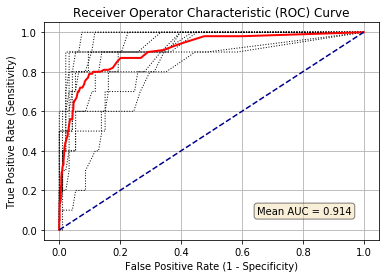

In [271]:
results = check_thresholds(X,y)

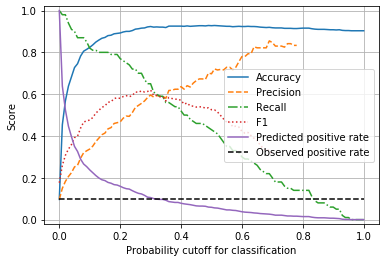

In [272]:
plot_thresholds(results)

A probability threshold of about 0.3 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [273]:
threshold = 0.3

In [274]:
results = final_random_forest(X,y)

In [275]:
# Look at accuracy
results[0]

0.9235716952949963

In [276]:
# Look at precision and recall
results[1:3]

[0.596033411033411, 0.65]

In [277]:
# Look at predicted positive rate
results[4]

0.10542382374906648

## Vehicle crime

In [278]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['vehicle_crime'], bin_edges = pd.qcut(devon_cornwall['vehicle_crime'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [279]:
# Have a look at counts
devon_cornwall['vehicle_crime'].value_counts()

0    932
1    102
Name: vehicle_crime, dtype: int64

In [280]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0        0.0     0
1       31.0     1

In [281]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['vehicle_crime'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [282]:
initial = initial_rf_regression(X,y)

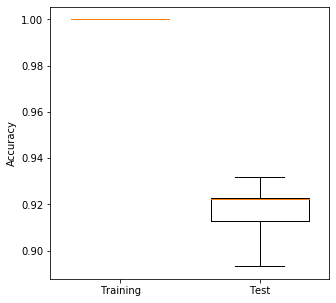

In [283]:
plot_initial_accuracy(initial)

In [284]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5   split_6  \
outdoors_score    0.021407  0.022802  0.020345  0.021682  0.027910  0.033873   
private_rent      0.016218  0.020199  0.021828  0.019859  0.019802  0.019934   
new_eu_birth      0.016914  0.020196  0.023461  0.020439  0.019730  0.021120   
married           0.020049  0.018020  0.018996  0.022291  0.018780  0.017907   
british_birth     0.007310  0.013224  0.015591  0.019865  0.011912  0.014406   
room_rating       0.010147  0.012634  0.014547  0.016056  0.010415  0.010456   
single            0.011554  0.008283  0.010301  0.012294  0.017578  0.007571   
wider_barriers    0.009739  0.007156  0.011444  0.011998  0.009127  0.012383   
m_33              0.004267  0.015430  0.015029  0.010258  0.010561  0.013030   
semi_detached     0.009311  0.009188  0.020083  0.011660  0.011780  0.011454   
white             0.010935  0.011836  0.012866  0.014324  0.014606  0.007775   
black             0.013513  0.010111  0.010149  0.013072  0.013681  0.009472   
detached          0.011896  0.009241  0.006151  0.010283  0.010663  0.013416   
flat              0.010599  0.006180  0.010457  0.011054  0.008996  0.010188   
m_35              0.012807  0.008936  0.009058  0.010756  0.011636  0.009514   
mixed             0.008947  0.009103  0.006854  0.011898  0.007044  0.009174   
m_25              0.011125  0.006545  0.013141  0.005986  0.010738  0.004343   
m_32              0.007193  0.011662  0.008822  0.008076  0.009393  0.011935   
chinese           0.010512  0.007783  0.008156  0.007652  0.007947  0.004671   
m_29              0.007651  0.008540  0.008688  0.004667  0.005756  0.005218   
bangladeshi       0.003998  0.007393  0.009194  0.006543  0.007716  0.007761   
f_23              0.008752  0.006674  0.005338  0.003308  0.009428  0.009730   
health_score      0.005646  0.006379  0.005075  0.008629  0.003768  0.006632   
finance           0.006968  0.006538  0.008677  0.007513  0.004862  0.007372   
imd               0.009294  0.006551  0.005438  0.007234  0.006941  0.005491   
m_24              0.003993  0.004942  0.002733  0.004644  0.005293  0.011185   
f_22              0.004634  0.007605  0.004696  0.007270  0.008823  0.006860   
f_26              0.007007  0.006706  0.006105  0.007668  0.007007  0.004173   
employment_score  0.009352  0.006779  0.006945  0.005371  0.002948  0.006938   
f_28              0.006807  0.005602  0.006916  0.005891  0.004396  0.006869   

                   split_7   split_8   split_9  split_10      mean  
outdoors_score    0.021858  0.026381  0.022948  0.019933  0.023914  
private_rent      0.020226  0.013865  0.018623  0.023703  0.019426  
new_eu_birth      0.026143  0.011317  0.018378  0.015073  0.019277  
married           0.017611  0.013559  0.015728  0.022061  0.018500  
british_birth     0.012158  0.015547  0.016715  0.014855  0.014158  
room_rating       0.017440  0.011520  0.008424  0.014916  0.012655  
single            0.013408  0.011430  0.013799  0.014723  0.012094  
wider_barriers    0.010614  0.014712  0.014638  0.014508  0.011632  
m_33              0.011708  0.008260  0.016966  0.010737  0.011625  
semi_detached     0.009749  0.006662  0.014047  0.009968  0.011390  
white             0.012128  0.009660  0.007440  0.008771  0.011034  
black             0.010604  0.009812  0.012694  0.006509  0.010962  
detached          0.010878  0.006950  0.010599  0.006774  0.009685  
flat              0.008605  0.009117  0.008673  0.012206  0.009608  
m_35              0.012944  0.007377  0.004705  0.006714  0.009445  
mixed             0.006283  0.011323  0.013485  0.006912  0.009102  
m_25              0.013645  0.006802  0.010437  0.007338  0.009010  
m_32              0.005739  0.010672  0.007427  0.007955  0.008887  
chinese           0.008540  0.007897  0.009073  0.007948  0.008018  
m_29              0.008660  0.007637  0.009057  0.005536  0.007141  
bangladeshi       0.007448  0.004972  0.008854  0.006362  0.007024  
f_23              0.

In [285]:
top_features = top_30_features(initial)

In [286]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('vehicle_crime')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('vehicle_crime',axis=1) 
y_df = feature_selected['vehicle_crime'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [287]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.9min finished


{'n_estimators': 400,
 'min_samples_split': 2,
 'min_samples_leaf': 4,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [288]:
best = best_rf_regression(X,y)

In [289]:
# Look at accuracies
best[0:2]

(0.9577691925666703, 0.9206777445855115)

In [290]:
# Look at ROC AUC
best[2:4]

(0.9920446243960892, 0.8516073916931844)

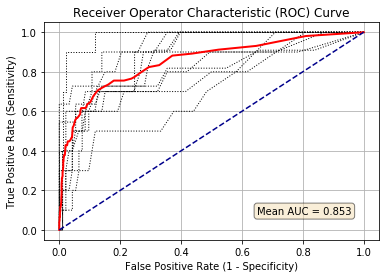

In [291]:
results = check_thresholds(X,y)

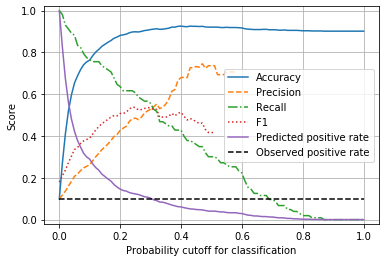

In [292]:
plot_thresholds(results)

A probability threshold of about 0.3 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [293]:
threshold = 0.3

In [294]:
results = final_random_forest(X,y)

In [295]:
# Look at accuracy
results[0]

0.9090832710978342

In [296]:
# Look at precision and recall
results[1:3]

[0.527835497835498, 0.5563636363636364]

In [297]:
# Look at predicted positive rate
results[4]

0.10249253174010456

## Violence and sexual offences

In [298]:
# Transform crime number column into labelled deciles and save bin edges
bin_labels = [0,1]
devon_cornwall['violence_sexual'], bin_edges = pd.qcut(devon_cornwall['violence_sexual'],
                                        q=[0, 0.9, 1],
                                        labels=bin_labels,
                                        retbins=True)

In [299]:
# Have a look at counts
devon_cornwall['violence_sexual'].value_counts()

0    930
1    104
Name: violence_sexual, dtype: int64

In [300]:
# Have a look at bin edges
results_table = pd.DataFrame(zip(bin_edges, bin_labels),
                             columns=['Threshold', 'Tier'])
results_table

Threshold  Tier
0       14.0     0
1      251.7     1

In [301]:
# Split data into two dataframes
X_df = devon_cornwall.drop(['antisocial','bike_theft','burglary','damage_arson','drugs','other_crime','other_theft',
                        'possession_weapons','public_order','robbery','shoplifting','theft_person','vehicle_crime',
                        'violence_sexual', 'crime_total'],axis=1) 
y_df = devon_cornwall['violence_sexual'] 

# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [302]:
initial = initial_rf_regression(X,y)

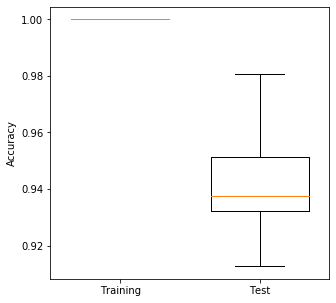

In [303]:
plot_initial_accuracy(initial)

In [304]:
# Look at top features ordered by importance
initial[2].head(30)

split_1   split_2   split_3   split_4   split_5   split_6  \
married           0.041470  0.041708  0.047068  0.048083  0.038279  0.042820   
two_plus_cars     0.039399  0.033162  0.034636  0.035311  0.031297  0.032508   
imd               0.035594  0.029304  0.030859  0.033766  0.039958  0.029687   
wider_barriers    0.039896  0.037451  0.025208  0.032923  0.025987  0.031698   
room_rating       0.022519  0.029341  0.035621  0.030091  0.024142  0.034753   
owners            0.019126  0.025706  0.020784  0.024046  0.022785  0.025492   
unemployment      0.024670  0.013629  0.020225  0.027221  0.020003  0.028987   
semi_detached     0.026278  0.016799  0.023528  0.019293  0.015172  0.020846   
employment_score  0.020130  0.014523  0.019955  0.016904  0.026490  0.026698   
health_score      0.023344  0.020202  0.017224  0.020547  0.019618  0.020165   
idaopi            0.019948  0.014849  0.020051  0.021433  0.019858  0.018024   
single            0.014598  0.016992  0.019773  0.021903  0.017024  0.016833   
flat              0.025517  0.013268  0.023185  0.014191  0.014313  0.025129   
new_eu_birth      0.011245  0.020860  0.018106  0.017393  0.020746  0.014938   
private_rent      0.014800  0.016931  0.013142  0.011357  0.008464  0.015599   
income_score      0.011049  0.014093  0.010264  0.015498  0.013848  0.017365   
british_birth     0.013138  0.014449  0.010433  0.011767  0.012644  0.009854   
m_33              0.012957  0.015342  0.016180  0.010998  0.016356  0.008008   
mixed             0.010819  0.010779  0.011262  0.010498  0.013996  0.011902   
language          0.008006  0.011663  0.010109  0.005944  0.009288  0.015131   
divorced          0.009614  0.007054  0.009796  0.011779  0.008064  0.009881   
white             0.005474  0.009202  0.010508  0.008580  0.010362  0.009672   
m_24              0.008012  0.009820  0.008786  0.008581  0.007303  0.004125   
education_score   0.008062  0.006414  0.009665  0.005973  0.009368  0.010286   
m_28              0.006826  0.006666  0.006974  0.005977  0.008055  0.010107   
m_25              0.006494  0.006994  0.005371  0.006752  0.008138  0.007875   
public_transport  0.004044  0.009484  0.004306  0.003867  0.014666  0.008267   
f_24              0.005268  0.008387  0.006696  0.004666  0.009504  0.007579   
children_score    0.008180  0.005335  0.005813  0.006161  0.003948  0.008378   
detached          0.007085  0.005603  0.004421  0.004959  0.007061  0.008044   

                   split_7   split_8   split_9  split_10      mean  
married           0.044228  0.036369  0.039113  0.041263  0.042040  
two_plus_cars     0.040947  0.043342  0.031327  0.040358  0.036229  
imd               0.028271  0.038191  0.034323  0.030040  0.032999  
wider_barriers    0.029824  0.028922  0.033834  0.039523  0.032527  
room_rating       0.035467  0.035217  0.025937  0.030005  0.030309  
owners            0.023980  0.019516  0.024539  0.030172  0.023615  
unemployment      0.018922  0.022347  0.027214  0.024491  0.022771  
semi_detached     0.018704  0.021272  0.020346  0.021361  0.020360  
employment_score  0.016916  0.016693  0.018737  0.016668  0.019372  
health_score      0.016662  0.016922  0.022343  0.014660  0.019169  
idaopi            0.020559  0.018199  0.016886  0.014794  0.018460  
single            0.018942  0.016274  0.019681  0.018454  0.018047  
flat              0.018343  0.014048  0.011224  0.018136  0.017736  
new_eu_birth      0.011073  0.012526  0.010982  0.018337  0.015621  
private_rent      0.014784  0.017312  0.016171  0.009064  0.013762  
income_score      0.013856  0.009874  0.017166  0.013619  0.013663  
british_birth     0.016049  0.013685  0.013845  0.013742  0.012961  
m_33              0.009372  0.012528  0.014158  0.008750  0.012465  
mixed             0.015113  0.010849  0.013133  0.012694  0.012105  
language          0.008585  0.007659  0.012038  0.010292  0.009871  
divorced          0.009988  0.009729  0.008878  0.009203  0.009399  
white             0.

In [305]:
top_features = top_30_features(initial)

In [306]:
# Create a new dataframe of these top features and separate into X and y
top_features.append('violence_sexual')
feature_selected = devon_cornwall[top_features]
# Split data into two dataframes
X_df = feature_selected.drop('violence_sexual',axis=1) 
y_df = feature_selected['violence_sexual'] 
# Convert dataframes to NumPy arrays
X = X_df.values
y = y_df.values

In [307]:
best_parameters = random_search(random_grid, X, y)
best_parameters

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.6s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:  2.8min finished


{'n_estimators': 400,
 'min_samples_split': 10,
 'min_samples_leaf': 4,
 'max_features': 'auto',
 'max_depth': 70,
 'bootstrap': True}

In [308]:
best = best_rf_regression(X,y)

In [309]:
# Look at accuracies
best[0:2]

(0.9731351420024715, 0.9419809559372666)

In [310]:
# Look at ROC AUC
best[2:4]

(0.9965644506655273, 0.9527370478983382)

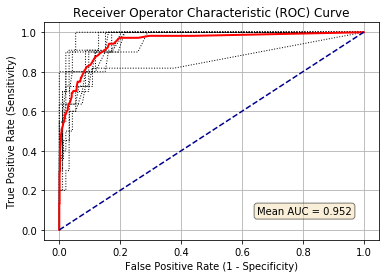

In [311]:
results = check_thresholds(X,y)

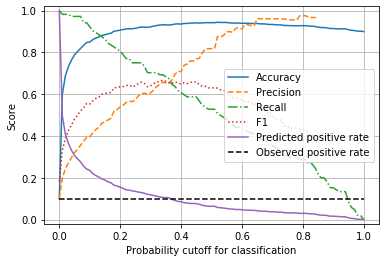

In [312]:
plot_thresholds(results)

A probability threshold of about 0.36 balances accuracy, precision and recall and correctly estimates the proportion of LSOAs with high crime. 

Let's put this together into a final model:

In [313]:
threshold = 0.36

In [314]:
results = final_random_forest(X,y)

In [315]:
# Look at accuracy
results[0]

0.9304051530993279

In [316]:
# Look at precision and recall
results[1:3]

[0.6512509712509713, 0.6745454545454546]

In [317]:
# Look at predicted positive rate
results[4]

0.10443427931292008